# R C3X fidelity check

24 Dec 2019

origined by rum

---
In this code, two types of R-Toffoli gate are checked fidelity on real device

In [6]:
## import tools
## Import numpy 
import numpy as np
from numpy import pi

## import plot tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
## To plot heatmap
import seaborn as sns

## import datetime
from datetime import datetime

## Import qiskit tools
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

## import qiskit backend monitor
from  qiskit.tools.monitor import backend_monitor

## import qiskit readout error mitigation tools
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

---
# 1. Get device

In [7]:
IBMQ.load_account()

/Users/Yasuhiro/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Here to choose provider

In [8]:
## keio-internal device
provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='keio-students')

## reservations
# provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='reservations')

## open device
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

### Define the backend device

In [9]:
device = provider.get_backend("ibmq_ourense")

---
# 2. Define circuit

### 2-1. Define R-Toffoli as function

---
### R-Toffoli_m
<img src="../img/RToffoli_m.png" />

In [10]:
## define RTof function
def RTof_m(qc, c1, c2, t):
    qc.ry(pi/4, t)
    qc.cx(c2, t)
    qc.ry(pi/4, t)
    qc.cx(c1, t)
    qc.ry(-pi/4, t)
    qc.cx(c2, t)
    qc.ry(-pi/4, t)

---
### R-Toffoli_ix
<img src="../img/RToffoli_ix.png" />

In [11]:
def RTof_ix(qc, c1, c2, t):
#     qc.h(t)
#     qc.t(t)
    qc.u2(pi/4, pi, t)
    qc.cx(c2, t)
    qc.tdg(t)
    qc.cx(c1, t)
    qc.t(t)
    qc.cx(c2, t)
#     qc.tdg(t)
#     qc.h(t)
    qc.u2(0, 3*pi/4, t)

---
### Toffoli gate with one swap
<img src = "../img/Toffoli_SWAP.png" />

In [12]:
## Toffoli gate with one swap
def Toffoli_SWAP(circuit, control1,  control2, target):
    
    """
    c1, c2, t => c1, t, c2
    """
    
    circuit.h(target)
    circuit.cx(control1, target)
    circuit.tdg(target)
    circuit.cx(control2, target)
    circuit.t(target)
    circuit.cx(control1, target)
    circuit.tdg(target)
    circuit.cx(target, control2) ## SWAP
    circuit.cx(control2, target) ## SWAP
    circuit.t(control1)
    circuit.t(control2)
    circuit.cx(target ,control1)
    circuit.tdg(control1)
    circuit.h(control2)
    circuit.t(target)
    circuit.cx(target, control1)

### 2-2. Compose circuit

In [13]:
## define qubit label as num_qubits
num_qubits = len(device.configuration().gates[0].coupling_map)


## Define the list to store the circuit lists of each qubits of the processor
RTof_qc = []


## define init_list
init_list = [format(j, '04b') for j in range(16)]


## define qubit
anc, c1, c2, c3, targ = [0, 1, 2, 3, 4]

In [14]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(num_qubits, "q")
    cr = ClassicalRegister(4, "c")
    circuit = QuantumCircuit(qr, cr)



    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[c1])
    if(init[1] == '1'):
        circuit.x(qr[c2])
    if(init[2] == '1'):
        circuit.x(qr[c3])
    if(init[3] == '1'):
        circuit.x(qr[int(targ)])

    ## R-C3X_m
    RTof_m(circuit, qr[c1], qr[c2], qr[anc])
    Toffoli_SWAP(circuit, qr[anc], qr[c3], qr[targ])
    RTof_m(circuit, qr[c1], qr[c2], qr[anc])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[c1], cr[3])
    circuit.measure(qr[c2], cr[2])
    circuit.measure(qr[c3], cr[0])
    circuit.measure(qr[targ], cr[1])


    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [15]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(num_qubits, "q")
    cr = ClassicalRegister(4, "c")
    circuit = QuantumCircuit(qr, cr)

    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[c1])
    if(init[1] == '1'):
        circuit.x(qr[c2])
    if(init[2] == '1'):
        circuit.x(qr[c3])
    if(init[3] == '1'):
        circuit.x(qr[int(targ)])

    ## R-C3X_ix
    RTof_ix(circuit, qr[c1], qr[c2], qr[anc])
    Toffoli_SWAP(circuit, qr[anc], qr[c3], qr[targ])
    RTof_ix(circuit, qr[c1], qr[c2], qr[anc])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[c1], cr[3])
    circuit.measure(qr[c2], cr[2])
    circuit.measure(qr[c3], cr[0])
    circuit.measure(qr[targ], cr[1])


    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [16]:
RTof_qc[0].draw()

---
# 3. Run on QASM simulator

### 3-1. Execution

In [17]:
## define simulator
simulator = Aer.get_backend("qasm_simulator")

## define shots
shots = 8192

## define repeat length
in_len = len(init_list)

## define job
job_sim = execute(RTof_qc, backend = simulator, shots = shots)
result_sim = job_sim.result()


## define the list to imidiately store the counts of the each circuit
## repeat # of each angle circuits times
counts_sim_m = [result_sim.get_counts(init) for init in range(in_len)]
counts_sim_ix = [result_sim.get_counts(init) for init in range(in_len, 2*in_len)]

In [18]:
print('counts_sim_m = ', counts_sim_m)

counts_sim_m =  [{'0000': 8192}, {'0001': 8192}, {'0010': 8192}, {'0011': 8192}, {'0100': 8192}, {'0101': 8192}, {'0110': 8192}, {'0111': 8192}, {'1000': 8192}, {'1001': 8192}, {'1010': 8192}, {'1011': 8192}, {'1100': 8192}, {'1101': 8192}, {'1111': 8192}, {'1110': 8192}]


In [19]:
print('counts_sim_ix = ', counts_sim_ix)

counts_sim_ix =  [{'0000': 8192}, {'0001': 8192}, {'0010': 8192}, {'0011': 8192}, {'0100': 8192}, {'0101': 8192}, {'0110': 8192}, {'0111': 8192}, {'1000': 8192}, {'1001': 8192}, {'1010': 8192}, {'1011': 8192}, {'1100': 8192}, {'1101': 8192}, {'1111': 8192}, {'1110': 8192}]


### 3-2. Plot the result

In [20]:
## define length of repeat
input_len = len(counts_sim_m)
output_bin = [format(num, '04b') for num in range(16)]


sim_m_data = [[(counts_sim_m[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]
sim_ix_data = [[(counts_sim_ix[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]

########################## R-C3X_m ############################


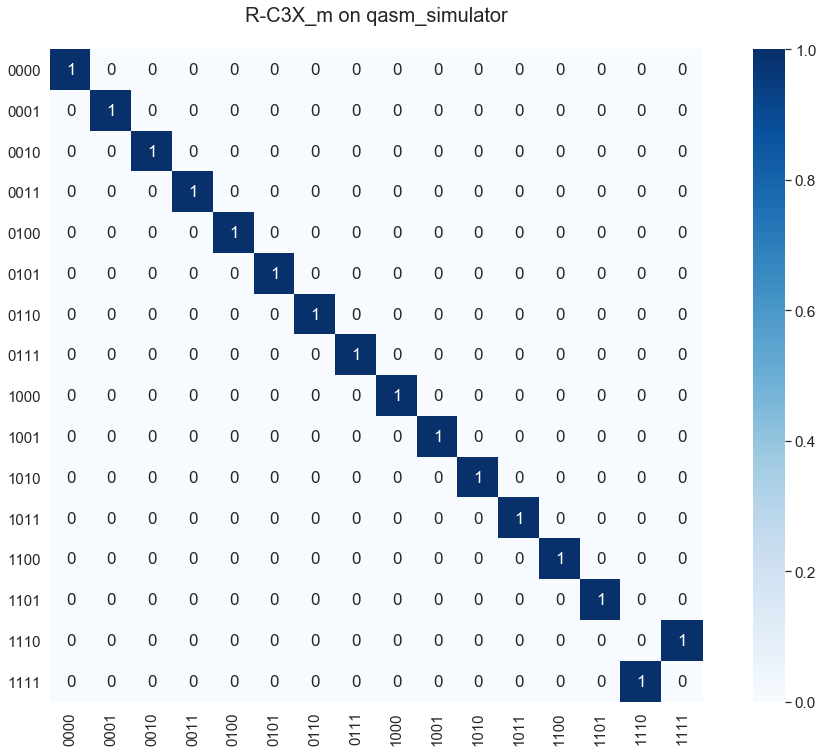

########################## R-C3X_ix ############################


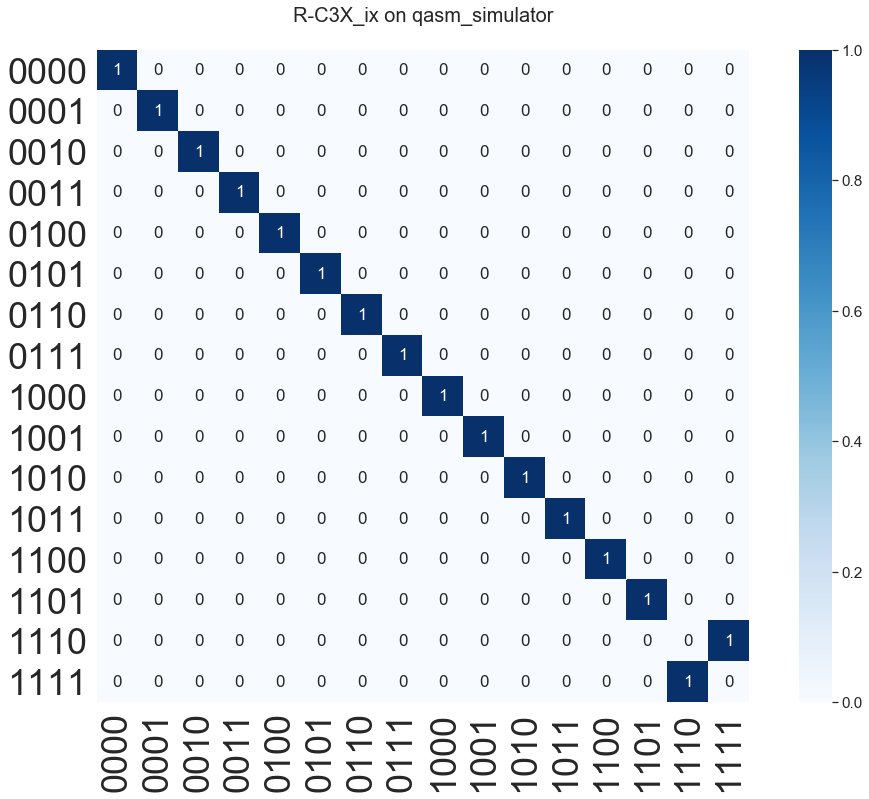

In [21]:
print("########################## R-C3X_m ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(16)]
### labels 
X = [format(num, "04b") for num in range(16)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
plt.title("R-C3X_m on "+str(simulator)+"\n", 
          fontsize=20
         )

## plot data
sns.heatmap(sim_m_data, 
            vmin = 0.0,  ## define maximum value
            vmax=1.0,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues') ## define the color
           )

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=15
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=15)

plt.show()

print("########################## R-C3X_ix ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(16)]
### labels 
X = [format(num, "04b") for num in range(16)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
plt.title("R-C3X_ix on "+str(simulator)+"\n", 
          fontsize=20
         )

## plot data
sns.heatmap(sim_ix_data, 
            vmin = 0.0,  ## define maximum value
            vmax=1.0,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues') ## define the color
           )

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=36
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=36)

plt.show()

---
# 4. Run on Realdevice

In [22]:
# backend_monitor(device)

### 4-1. finding the qubit mapping list

In [23]:
## Get qubit coupling map
conf = device.configuration()
coupling_map = conf.coupling_map
print(coupling_map)

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]


In [24]:
## searching the qubit mapping list from coupling_map
from collections import Counter
import copy
    
hub_list = [qubit for qubit, cnt in Counter(np.ravel(coupling_map)).most_common() if cnt>=6]

t_qubit_list = []
for hub in hub_list:
    branch = [con[1] for con in coupling_map if con[0]==hub]
    tale_list = [tale for tale in coupling_map if(tale[1]!=hub and tale[1] not in branch) for bra in branch if(tale[0]==bra)]
    
    tale_mapping_list = []
    for tale in tale_list:
        
        t_list = []
        t_list.append(hub)
        for bra in branch:
            if bra != tale[0]:
                t_list.append(bra)
        t_list.extend(tale)
        tale_mapping_list.append(t_list)
    
    t_qubit_list.append(tale_mapping_list)


qubit_mapping = []
for hub_map in t_qubit_list:
    tale_mapping = []
    for tale_map in hub_map:
        mapping1 = copy.copy(tale_map)
        tale_mapping.append(mapping1)
        
        tale_map[1], tale_map[2] = tale_map[2], tale_map[1]

        mapping2 = copy.copy(tale_map)
        tale_mapping.append(mapping2)
    qubit_mapping.append(tale_mapping)
    
## mitigation mapping


print("qubit_mapping = ", qubit_mapping)

qubit_mapping =  [[[1, 0, 2, 3, 4], [1, 2, 0, 3, 4]]]


In [25]:
qubit_mapping = [[[1, 0, 2, 3, 4], [1, 2, 0, 3, 4]]]
cal_mapping = [[[0, 2, 3, 4], [2, 0, 3, 4]]]

### 4-2. Define mitigation circuit

In [26]:
qr = QuantumRegister(4)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [27]:
print(meas_calibs)
print(state_labels)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f131080>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f131438>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f131710>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f1318d0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f131a90>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f131cc0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f131be0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f0beda0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f0bee48>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f0be668>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f0bea20>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f129a20>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f129fd0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1f129eb8>, <qisk

### 4-3. Execution

In [28]:
# ## define shots
# shots = 8192

# ## define the lists to store job_id
# job_id_list = []
# cal_job_id_list = []

# # result_exp_list = []
# # result_cal_exp_list = []

# ## repeat # of qubit_mapping times
# for hub, cal_hub in zip(qubit_mapping, cal_mapping):
#     for mapping, cal_map in zip(hub, cal_hub):
    
#         ## job for circuit execution
#         job_exp = execute(RTof_qc,
#                           backend = device,
# #                           backend = simulator,
#                           shots = shots,
#                           initial_layout=mapping,
#                           optimization_level = 0
#                          )
#         job_id_list.append(job_exp.job_id())
#         print('sent the job', mapping)


#         ## job for meas_cal
#         cal_job = execute(meas_calibs, 
#                         backend = device,
# #                           backend = simulator,
#                         shots=shots,
#                         initial_layout=cal_map,
#                         optimization_level=0
#                         )
#         cal_job_id_list.append(cal_job.job_id())
#         print('sent the cal_job', mapping)

# #         ## get results
# #         result_exp = job_exp.result()
# #         result_cal = cal_job.result()

# #         result_exp_list.append(result_exp)
# #         result_cal_exp_list.append(result_cal)

# print('job_id_list = ', job_id_list)
# print('cal_job_id_list = ', cal_job_id_list)

In [29]:
job_id_list =  ['5e01de3327f7840012679c0d', '5e01de3c58c50e0012c338ab']
cal_job_id_list =  ['5e01de3727f7840012679c0e', '5e01de3f76be6000126d8cf0']

### 4-4. retrieve the job and get the result

In [30]:
        ## Define the list to store the result_exp for error mitigation
result_exp_list = []
result_cal_exp_list = []

for job_id, cal_job_id in zip(job_id_list, cal_job_id_list):
    ## retrieve jobs
    retrieved_job = device.retrieve_job(job_id)
    retrieved_cal_job = device.retrieve_job(cal_job_id)
    print("jobs were retrieved")
    result_exp = retrieved_job.result()
    print("got exp result")
    result_cal_exp = retrieved_cal_job.result()
    print("got cal_exp result")
    ## Append results_exp to the result_exp_list for error mitigation operation
    result_exp_list.append(result_exp)
    result_cal_exp_list.append(result_cal_exp)

print(result_exp_list)
print(result_cal_exp_list)

jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
[Result(backend_name='ibmq_ourense', backend_version='1.0.1', date=datetime.datetime(2019, 12, 24, 11, 7, 29, tzinfo=datetime.timezone.utc), execution_id='dfc2ca4e-263c-11ea-82dd-ac1f6b47c318', header=Obj(backend_name='ibmq_ourense', backend_version='1.0.1'), job_id='5e01de3327f7840012679c0d', qobj_id='2a00dd20-aa64-40c4-9c9f-1e1f0657c7e6', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=4360, 0x1=1665, 0x2=781, 0x3=682, 0x4=167, 0x5=64, 0x6=47, 0x7=22, 0x8=191, 0x9=72, 0xa=62, 0xb=63, 0xc=8, 0xd=4, 0xe=2, 0xf=2)), header=Obj(clbit_labels=[['c', 0], ['c', 1], ['c', 2], ['c', 3]], creg_sizes=[['c', 4]], memory_slots=4, n_qubits=5, name='circuit0', qreg_sizes=[['q', 5]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4]]), meas_level=2, memory=False, shots=8192, success=True), ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=2003, 0x1=4019, 

In [46]:
counts_list = [[result.get_counts(num_input)  for num_input in range(16)] for result in result_exp_list]

In [86]:
print(counts_list)

[[{'0000': 4360, '0011': 682, '1101': 4, '0100': 167, '1100': 8, '0001': 1665, '1000': 191, '1010': 62, '1110': 2, '1001': 72, '0111': 22, '0110': 47, '1111': 2, '0010': 781, '0101': 64, '1011': 63}, {'0000': 2003, '0011': 724, '1101': 4, '0100': 67, '1100': 7, '0001': 4019, '1000': 81, '1010': 62, '1110': 1, '1001': 148, '0111': 41, '0110': 30, '1111': 6, '0010': 803, '0101': 145, '1011': 51}, {'0000': 1540, '0011': 1667, '1101': 4, '0100': 46, '1100': 7, '0001': 931, '1000': 85, '1010': 143, '1110': 5, '1001': 60, '0111': 74, '0110': 116, '1111': 10, '0010': 3392, '0101': 39, '1011': 73}, {'0000': 972, '0011': 3074, '1101': 4, '0100': 26, '1100': 1, '0001': 1532, '1000': 69, '1010': 126, '1110': 3, '1001': 74, '0111': 122, '0110': 70, '1111': 6, '0010': 1942, '0101': 45, '1011': 126}, {'0000': 609, '0011': 168, '1101': 120, '0100': 3795, '1100': 280, '0001': 227, '1000': 175, '1010': 59, '1110': 87, '1001': 101, '0111': 516, '0110': 802, '1111': 95, '0010': 183, '0101': 916, '1011': 

# Readout Error mitigation

The calibration matrix 

[[9.11865234e-01 3.36914062e-02 3.21044922e-02 5.49316406e-03
  1.11206055e-01 4.39453125e-03 8.30078125e-03 3.66210938e-04
  1.51245117e-01 6.83593750e-03 5.73730469e-03 3.66210938e-04
  2.30712891e-02 8.54492188e-04 9.76562500e-04 1.22070312e-04]
 [1.46484375e-02 8.93188477e-01 4.88281250e-04 3.08837891e-02
  2.92968750e-03 1.14013672e-01 0.00000000e+00 9.52148438e-03
  1.34277344e-03 1.45019531e-01 0.00000000e+00 4.51660156e-03
  2.44140625e-04 2.13623047e-02 0.00000000e+00 1.46484375e-03]
 [1.07421875e-02 6.10351562e-04 9.03564453e-01 3.40576172e-02
  9.76562500e-04 1.22070312e-04 1.07910156e-01 4.15039062e-03
  9.76562500e-04 0.00000000e+00 1.48193359e-01 4.63867188e-03
  2.44140625e-04 0.00000000e+00 2.39257812e-02 4.88281250e-04]
 [1.22070312e-04 1.13525391e-02 1.18408203e-02 8.67919922e-01
  0.00000000e+00 8.54492188e-04 2.31933594e-03 1.05590820e-01
  0.00000000e+00 2.07519531e-03 2.44140625e-03 1.34643555e-01
  0.00000000e+00 6.10351562e-04 0.00000000

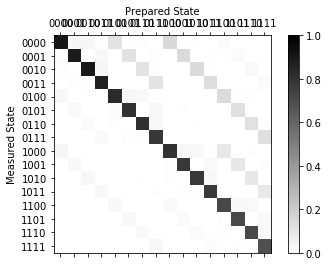

Average Measurement Fidelity: 0.797440 

The calibration matrix 

[[8.95629883e-01 3.01513672e-02 3.19824219e-02 4.63867188e-03
  1.19018555e-01 9.27734375e-03 4.76074219e-03 6.10351562e-04
  1.24877930e-01 4.76074219e-03 3.54003906e-03 1.09863281e-03
  2.01416016e-02 1.95312500e-03 1.22070312e-03 4.88281250e-04]
 [9.03320312e-03 8.68896484e-01 6.10351562e-04 3.05175781e-02
  1.83105469e-03 1.24511719e-01 1.22070312e-04 5.49316406e-03
  6.10351562e-04 1.28662109e-01 0.00000000e+00 6.10351562e-03
  3.66210938e-04 2.22167969e-02 1.22070312e-04 3.66210938e-04]
 [1.04980469e-02 6.10351562e-04 8.72802734e-01 2.51464844e-02
  2.92968750e-03 1.22070312e-04 1.18164062e-01 7.81250000e-03
  1.83105469e-03 0.00000000e+00 1.30737305e-01 4.15039062e-03
  1.22070312e-04 1.22070312e-04 1.98974609e-02 9.76562500e-04]
 [3.66210938e-04 1.08642578e-02 9.03320312e-03 8.51440430e-01
  0.00000000e+00 1.46484375e-03 1.22070312e-03 1.18164062e-01
  0.00000000e+00 1.46484375e-03 1.09863281e-03 1.27197266e-01
 

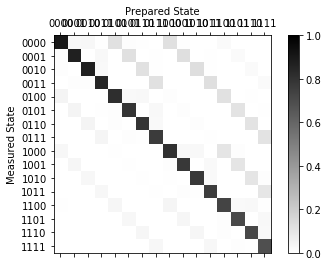

Average Measurement Fidelity: 0.789009 



In [26]:
meas_fitter_list = []

for result_cal_exp in result_cal_exp_list:
    
    ## define measurement fitter
    meas_fitter = CompleteMeasFitter(result_cal_exp, state_labels)
    meas_fitter_list.append(meas_fitter)
    
    print("The calibration matrix \n")
    print(meas_fitter.cal_matrix)

    ## Plot the calibration matrix
    print("Plot the calibration matrix (2D color grid plot)\n")
    meas_fitter.plot_calibration()

    ## The measurement fidelity
    print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity(), "\n")

### Apply device calibration parameter to mitigate the result_exp

In [27]:
## define the list to store 
mitigated_m_list = []
mitigated_ix_list = []

## define repeat length
in_len = len(init_list)

## repeat (num_qubits) times
for result_exp, meas_fitter in zip(result_exp_list, meas_fitter_list):
    
    # Get the filter object
    meas_filter = meas_fitter.filter
    
    ## get measurement error mitigated result
    mitigated_results = meas_filter.apply(result_exp)
    mitigated_m_counts = [mitigated_results.get_counts(init) for init in range(in_len)]
    mitigated_ix_counts = [mitigated_results.get_counts(init) for init in range(in_len, 2*in_len)]
    
    ## Append mitigated_counts to mitigated_list
    mitigated_m_list.append(mitigated_m_counts)
    mitigated_ix_list.append(mitigated_ix_counts)

### Show the mitigated counts

In [28]:
print("mitigated_m_list = ", mitigated_m_list, "\n")
print("mitigated_ix_list = ", mitigated_ix_list, "\n")

mitigated_m_list =  [[{'0110': 34.49556738357605, '1000': 44.940322254065705, '0111': 3.8528731143679362, '0000': 4672.594725479246, '0101': 17.402748466157295, '1011': 51.54266494075903, '0001': 1754.413338114629, '1101': 0.5466922049543098, '0010': 767.8950780656847, '1001': 25.32110765362815, '0100': 32.88814497861569, '0011': 742.8076382015238, '1010': 43.299099142792}, {'1100': 2.3259929600863276, '0110': 11.685948611621285, '1000': 7.845544132245776, '1111': 3.815326398920415, '0111': 25.44265939245445, '0000': 1996.3596168159931, '0101': 29.578821172610237, '1011': 33.45044701798117, '0001': 4430.920951244976, '1101': 5.022271796573455e-15, '0010': 823.9876893955285, '1001': 27.522211129612444, '0100': 3.172958315360297e-15, '0011': 755.3868421769473, '1010': 43.677949551021136}, {'1100': 4.375086140464396, '0110': 45.397127314566305, '1000': 31.22633606152038, '0001': 943.3206596060049, '1101': 1.4978468304679198, '1001': 36.56826840756135, '0100': 4.759898258963752e-15, '1010'

In [118]:
mitigated_m_list =  [[{'0110': 34.49556738357605, '1000': 44.940322254065705, '0111': 3.8528731143679362, '0000': 4672.594725479246, '0101': 17.402748466157295, '1011': 51.54266494075903, '0001': 1754.413338114629, '1101': 0.5466922049543098, '0010': 767.8950780656847, '1001': 25.32110765362815, '0100': 32.88814497861569, '0011': 742.8076382015238, '1010': 43.299099142792}, {'1100': 2.3259929600863276, '0110': 11.685948611621285, '1000': 7.845544132245776, '1111': 3.815326398920415, '0111': 25.44265939245445, '0000': 1996.3596168159931, '0101': 29.578821172610237, '1011': 33.45044701798117, '0001': 4430.920951244976, '1101': 5.022271796573455e-15, '0010': 823.9876893955285, '1001': 27.522211129612444, '0100': 3.172958315360297e-15, '0011': 755.3868421769473, '1010': 43.677949551021136}, {'1100': 4.375086140464396, '0110': 45.397127314566305, '1000': 31.22633606152038, '0001': 943.3206596060049, '1101': 1.4978468304679198, '1001': 36.56826840756135, '0100': 4.759898258963752e-15, '1010': 44.455977304380966, '1110': 7.596259233612346e-16, '1111': 7.725275638325896, '0111': 34.80152935049182, '0000': 1507.5405167077074, '0101': 11.93370546910625, '1011': 20.68690911380821, '0010': 3652.4309845382472, '0011': 1850.0397775173478}, {'0110': 22.81978617061976, '1000': 35.95869271736526, '0111': 48.940722578119534, '0000': 908.4486916201862, '1011': 26.453183786304507, '0001': 1572.288843814927, '1101': 5.4758003415877193e-14, '0010': 1988.83437032562, '1001': 27.077179984457704, '0011': 3482.259598235224, '1010': 78.91893076717672}, {'1100': 202.44445360667999, '0110': 896.2351454699913, '1000': 167.34742982919022, '0001': 76.50632147874765, '1101': 114.70699747392558, '1001': 103.0634023977594, '0100': 4455.573493260174, '1010': 51.099758556756, '1110': 76.95047401798969, '1111': 107.85202561244816, '0111': 610.4822207784391, '0000': 70.93690165883463, '0101': 1030.44969099523, '1011': 53.78984246316917, '0010': 71.98748489766928, '0011': 102.57435750299368}, {'1100': 123.38890563515702, '0110': 594.9931588471247, '1000': 61.47810906372681, '0001': 122.43640964654452, '1101': 204.44945231411586, '1001': 173.9552578526165, '0100': 1034.4302428588737, '1010': 40.426004156578344, '1110': 100.84225325394198, '1111': 84.6306037594353, '0111': 865.4945949618505, '0000': 200.00258580492152, '0101': 4386.390318931527, '1011': 78.13218460149109, '0010': 52.23216779633612, '0011': 68.71775051575915}, {'1100': 33.439245910661974, '0110': 3148.5233087293173, '1000': 16.11471829498276, '0001': 330.3561793755718, '1101': 38.56481534992534, '1001': 12.232413074445995, '0100': 1327.6446765191683, '1010': 14.130561274587672, '1110': 20.984353314734015, '1111': 61.46125285960492, '0111': 1103.5800743158973, '0000': 433.3413034906165, '0101': 743.6487182806172, '1011': 16.822421173880723, '0010': 523.6754571888122, '0011': 367.48050084717664}, {'1110': 71.74506195796204, '0110': 1163.9781791198059, '1000': 18.49473272923722, '1111': 35.599430568400074, '0111': 2908.188082894762, '0000': 327.70907265233683, '0101': 1320.5215372037471, '1011': 35.7115958412646, '0001': 427.1708917329317, '1101': 18.660508194399164, '0010': 466.941675801417, '1001': 25.19390286791433, '0100': 781.2376098694385, '0011': 567.9925521973948, '1010': 22.855166368989618}, {'1100': 5.676089007463112e-10, '1110': 2.3582884207422673e-10, '0110': 1.3215653066122723e-10, '1000': 4953.60381001172, '1111': 3.7573584317997454e-10, '0111': 1.5357734229897909e-10, '1011': 423.46182347285264, '1101': 5.319394102837109e-10, '1001': 2304.669582438149, '0011': 8.588519137572241e-11, '1010': 510.2647840815217}, {'1100': 5.988572272358703e-10, '1110': 1.2533874211960993e-09, '0110': 6.377425794331741e-10, '1000': 2269.0049606701045, '1111': 8.44885934840302e-10, '0111': 2.0007279838672895e-10, '1011': 676.4510095014248, '1101': 2.059560095729035e-09, '0010': 1.024173702435567e-09, '1001': 4847.951818042087, '1010': 398.59221180108693}, {'1100': 1.8612913769260714e-10, '1000': 1619.9416343377497, '1111': 8.171958115213996e-10, '0111': 2.1903168402007695e-10, '1011': 1900.2638083844074, '0101': 1.868373054275426e-10, '1101': 2.965857070573871e-10, '1001': 905.0426536908686, '0100': 3.9665244562959064e-11, '1010': 3766.7519035920636}, {'1100': 1.2566901742936091e-13, '0110': 4.115297321489532e-12, '1000': 904.9472627426567, '0001': 4.2464513774187987e-11, '1101': 6.752341867284998e-14, '1001': 1693.9377149235884, '0100': 4.859617197304273e-14, '1010': 1977.5868520386205, '1110': 1.182583562902466e-13, '1111': 5.3600422981217266e-14, '0111': 7.272156523004649e-12, '0000': 2.187693102087232e-11, '0101': 2.0308561626424468e-14, '1011': 3615.5281702949483, '0010': 6.684575178074211e-11, '0011': 1.012542423254467e-10}, {'1100': 5307.219972993454, '1110': 449.3983068038285, '0110': 9.355647764716274e-10, '1111': 486.98690591885963, '0111': 7.366412299797064e-10, '1011': 3.734653533975152e-10, '0001': 2.078858754232669e-10, '1101': 1948.394814303613, '0010': 9.249401795862133e-10, '0011': 7.445372823254307e-10, '1010': 5.957976655904467e-10}, {'1100': 2010.1129659705423, '1110': 517.032202481872, '0110': 1.5619080254198046e-10, '1111': 559.8383717055245, '0000': 1.823388022972817e-09, '0001': 5.253086999266623e-09, '1101': 5105.01645988131, '0011': 9.303363518603879e-10}, {'1100': 965.1250032813599, '1101': 1380.8695645521157, '1110': 2140.0213804633986, '0010': 3.7763375161823745e-12, '0011': 2.0288557135751715e-11, '1111': 3705.9840517047455, '0000': 7.148044822876103e-11}, {'1100': 1432.0950277344512, '1110': 3454.38184565452, '1111': 2202.821796537045, '0000': 1.7321709419192057e-10, '0001': 1.5035672112994125e-11, '1101': 1102.701330082562, '0010': 1.1218888900871204e-10, '0011': 3.9802416048214927e-10}], [{'1100': 6.309377731644056e-10, '1110': 7.357778839325868e-11, '0110': 41.62831664218792, '1000': 1.8096212250039156e-09, '1111': 2.428534565286633e-11, '0111': 58.67759147105781, '0000': 4934.50181081794, '1011': 2.1598383953720657e-10, '0001': 1622.723757597773, '1101': 1.6749919528637192e-10, '0010': 799.8222139277088, '1001': 7.716666238291592e-10, '0100': 34.144331073555406, '0011': 700.5019784662577, '1010': 2.999343544796834e-10}, {'1100': 6.756706583393047e-11, '1110': 8.730866371672516e-13, '0110': 15.064267216597164, '1000': 2.3388794609960567e-10, '1111': 3.504552855868818e-12, '0111': 29.205130481541243, '0000': 1730.1136003910437, '1011': 9.638113746636206e-11, '0001': 4810.106949776374, '1101': 1.5916551498291413e-10, '0010': 791.9558553170816, '1001': 6.612249858029906e-10, '0011': 815.5541968162541, '1010': 9.081483003483323e-11}, {'0110': 116.48655213470691, '0111': 71.02655770508403, '0000': 1169.566701525448, '0101': 2.2836598451818877, '0001': 666.453727646016, '0010': 4195.636263217862, '0100': 22.922270376033683, '0011': 1947.624267550432}, {'0110': 127.24487494896788, '0111': 59.150385391924154, '0000': 561.9101281923687, '0101': 1.0019218007334407e-10, '0001': 1085.498806374832, '0010': 2151.0612752760076, '0100': 1.0567357557576817e-10, '0011': 4207.134529816791}, {'1110': 32.03973090952756, '0110': 748.9899444621049, '1000': 180.59568913057953, '1111': 8.385713110809752, '0111': 545.6977607578136, '0000': 211.85462197534798, '0101': 1035.8843004978191, '1011': 20.928938391277498, '0001': 161.71175216299596, '1101': 32.30336126395632, '0010': 113.51308393227728, '1001': 47.03919478242603, '0100': 4960.933426545468, '0011': 60.80962548289667, '1010': 31.31285659470091}, {'1100': 21.87526895111326, '0110': 562.8001947020922, '1000': 71.29150570364791, '0001': 212.13107458599632, '1101': 28.92622490264953, '1001': 147.04780736220167, '0100': 1214.1159541275692, '1010': 58.82776892835183, '1110': 10.044352080061657, '1111': 8.307898316735704, '0111': 757.2612958668392, '0000': 147.98493452692523, '0101': 4777.9872921520555, '1011': 27.742091694934828, '0010': 75.43651154353977, '0011': 70.21982455528511}, {'1100': 176.73979930745992, '0110': 3377.3538823480076, '1000': 68.5281280652205, '0001': 120.52613777310127, '1101': 139.48620189693386, '1001': 65.25102141964994, '0100': 1223.0049125288594, '1010': 131.7049442531563, '1110': 130.12020471606903, '1111': 153.39380940974476, '0111': 1149.372267981702, '0000': 172.4631602812875, '0101': 661.6483742824478, '1011': 49.45605291836293, '0010': 303.9632634225031, '0011': 268.9878393954938}, {'1100': 125.83970735080591, '0110': 1310.2652950373858, '1000': 66.87598409128594, '0001': 95.53606082527185, '1101': 161.39387159598712, '1001': 63.91879790772744, '0100': 758.4988230112989, '1010': 110.53148337438105, '1110': 177.65627222471582, '1111': 191.7932351479087, '0111': 3054.2333583211002, '0000': 130.25574496930136, '0101': 1175.2580187981844, '1011': 117.8549325300309, '0010': 249.2801426528995, '0011': 402.808272161715}, {'1100': 4.036435702974123e-09, '1110': 1.0588092854583933e-08, '0110': 1.153206799053957e-09, '1000': 5171.729424074271, '1111': 8.644645988358322e-09, '0111': 1.6523366621985387e-09, '1011': 425.4995015221201, '1101': 6.718500157304489e-09, '1001': 1986.6251150271814, '1010': 608.1459594453104}, {'1100': 4.729569378348897e-09, '0110': 1.0138652500699258e-09, '1000': 2020.8192615575936, '0001': 4.800189477552092e-09, '1101': 8.378158602863218e-09, '1001': 5128.009479197931, '0100': 1.266994270647878e-10, '1010': 451.97057913832214, '1110': 7.776017130132928e-09, '1111': 8.653562248624865e-09, '0111': 5.828200969229858e-10, '0000': 1.7239437389458312e-09, '0101': 1.1108678437364706e-09, '1011': 591.2006801563884, '0010': 2.2970732840653762e-10, '0011': 3.0975022469135276e-10}, {'1100': 4.146879417535533e-09, '1110': 1.1514649700969395e-08, '1000': 1134.0412147587385, '1111': 12.309015302458072, '1011': 1835.5547131962237, '0101': 8.402339797794141e-10, '1101': 9.377235927543391e-09, '1001': 685.4781289768832, '1010': 4524.616927835878}, {'1100': 3.588844752222617e-09, '1110': 8.866371913203682, '1000': 529.0802489699072, '1111': 3.900836699154811e-09, '1011': 4386.9328771352075, '1101': 3.622432049774214e-09, '1001': 1117.1276315837893, '0100': 7.63384456912559e-10, '1010': 2149.992870434927}, {'1100': 5442.331107173074, '0110': 7.258578487654903e-18, '1000': 2.902276182802823, '0001': 7.030971834277052e-11, '1101': 1649.6934000456213, '1001': 1.2279774403936421e-09, '0100': 1.0126617062613441e-16, '1010': 1.8759871621888804e-09, '1110': 512.0144832347595, '1111': 585.0587333858022, '0111': 1.1897822048561174e-17, '0000': 1.9415184358433192e-10, '0101': 3.3355852865954394e-17, '1011': 2.640927512520243e-09, '0010': 3.063363500361321e-10, '0011': 4.771701241513254e-10}, {'1100': 1889.6634779878186, '1110': 537.9351373724479, '1000': 8.403948249115089e-10, '1111': 670.8679484093811, '0000': 5.71872902432808e-11, '1011': 2.1112350611439794e-09, '0001': 1.3753424420262555e-09, '1101': 5093.533436243502, '0010': 1.0587185603155127e-10, '1001': 6.150059326165099e-10, '0011': 2.3931088006311488e-11, '1010': 1.4197104534666254e-09}, {'1100': 699.4067345163076, '1110': 2254.4270729081754, '1000': 11.448597447726465, '1111': 4221.864276940898, '0001': 1.5173014893067369e-10, '1101': 983.9102129387953, '0010': 3.2038053847117866e-09, '1001': 4.762838695981553e-10, '0011': 2.550792186055391e-09, '1010': 20.94310529255319}, {'1100': 996.7326426560426, '1110': 4210.93842602569, '1000': 5.096809696571146e-10, '1111': 2241.614776791375, '0000': 3.135206199202708e-12, '1011': 12.005930689242335, '0001': 1.695831099185146e-09, '1101': 730.7082238911362, '0010': 3.850679515447035e-09, '1001': 4.066340771823927e-09, '0011': 2.5050120040579798e-09, '1010': 7.01932045409102e-10}]] 
mitigated_ix_list =  [[{'1100': 2.987169583842864, '1110': 3.259569023923707, '0110': 18.902014840821565, '1000': 35.19514982254369, '1111': 2.8599707739835725, '0111': 9.660824861588482, '0000': 4764.573945144536, '0101': 7.704278197044417, '1011': 73.73040252975011, '0001': 1633.8530686858517, '0010': 786.8298557821875, '1001': 52.33881806389122, '0100': 5.322485822217091, '0011': 758.3633972441054, '1010': 36.41904962371219}, {'1100': 1.1281633541715899, '0110': 14.333166718324387, '1000': 29.279259139585097, '0001': 4634.790497988513, '1101': 2.917316995615371e-15, '1001': 38.74868732966396, '0100': 8.759629770712863, '1010': 43.99738987404384, '1110': 3.478206034466112, '1111': 1.1718562431471071, '0111': 6.674638699175826, '0000': 1772.0801980674046, '0101': 41.84355143666072, '1011': 28.12155415721966, '0010': 751.3651318777256, '0011': 816.2280693091865}, {'1100': 93.6807724267229, '0110': 208.0802936395785, '1000': 53.53246435147499, '0001': 608.8440358317015, '1101': 85.45685598700263, '1001': 36.21059360083825, '0100': 117.8180469211018, '1010': 68.61916505878942, '1110': 175.7340921295355, '1111': 121.84351198177508, '0111': 246.8108359524899, '0000': 1281.2189113552993, '0101': 103.43689661979629, '1011': 85.86522798179587, '0010': 3595.492480685531, '0011': 1309.3558154765678}, {'1100': 60.93391496029893, '0110': 237.02707641653615, '1000': 41.281063672749234, '0001': 1294.1117964290127, '1101': 130.51430586208338, '1001': 23.723233612360712, '0100': 97.25881949567186, '1010': 91.04275870064676, '1110': 116.78471339788379, '1111': 211.73945262063503, '0111': 234.60578503365187, '0000': 580.8783115802221, '0101': 111.38805711579516, '1011': 88.54516368395693, '0010': 1351.9394180652434, '0011': 3520.2261293532524}, {'1100': 43.35257398555754, '1110': 45.77278267418165, '0110': 831.2231239035284, '1111': 65.35378710705412, '0111': 712.5581527961334, '1011': 3.719996402511769, '0101': 1649.7537322297544, '1101': 50.54411558788649, '0010': 2.4588569707997196e-12, '1001': 1.106381614734107e-12, '0100': 4771.535677154381, '0011': 18.18605815903655, '1010': 1.9410396700821465e-12}, {'1100': 27.373315701206515, '1110': 52.18560926263162, '0110': 742.4185099731964, '1000': 7.058645160706885e-13, '1111': 25.826551699961115, '0111': 763.4055752061828, '0101': 4815.518075499208, '1101': 12.172244888611326, '0010': 18.248950417487634, '0100': 1734.8511673515238}, {'1100': 20.694943166823194, '1110': 19.201086484258777, '0110': 3563.326682356083, '1000': 16.454516540471694, '1111': 89.78620478011591, '0111': 1048.2352792182214, '0000': 302.1824442466578, '0101': 556.6567914302921, '1011': 11.31493628120868, '0001': 214.9667773048875, '1101': 22.541538288798833, '0010': 592.0038599549293, '1001': 27.877152036318517, '0100': 1240.5612348687882, '0011': 466.196553042146}, {'1100': 20.24093515010115, '0110': 1276.2595230236404, '1000': 8.613517181016933, '0001': 261.5245702116973, '1101': 21.815649597247745, '1001': 19.499188931996553, '0100': 577.4571687590926, '1010': 10.895503346688642, '1110': 88.25860025183827, '1111': 3.5435792754973106e-15, '0111': 3448.0581809680225, '0000': 276.2612860654541, '0101': 1182.355520500218, '1011': 12.33441627204279, '0010': 427.30088985565675, '0011': 561.1250498852853}, {'1100': 6.263964507320515e-09, '1110': 1.7898284090763064e-09, '0110': 7.372872879971652e-10, '1000': 5064.350348881972, '1111': 2.0950931655795963e-09, '0111': 1.0289351760404295e-09, '1011': 380.12478948483556, '1101': 2.410445191967231e-09, '1001': 2112.079925105089, '0011': 2.841541920464869e-11, '1010': 635.4449365622702}, {'1000': 2063.122048796488, '0000': 9.427134426619786e-10, '0101': 3.4100413813443283e-10, '1011': 697.3067865629431, '0001': 3.252716831188629e-09, '1001': 5055.025376503225, '0100': 2.648693879665667e-11, '0011': 2.98072632749554e-10, '1010': 376.54578813415173}, {'0110': 1.1193117998732496e-09, '1000': 1541.417153391545, '1111': 5.3412542158295295, '0000': 4.79612733428255e-09, '1011': 1683.9723774376541, '0001': 1.7203808820982565e-09, '0010': 1.1578519747593178e-08, '1001': 836.3949066648684, '0100': 1.7526461473399837e-10, '0011': 7.003651264213273e-10, '1010': 4124.874308273892}, {'1100': 8.277349800123486e-10, '1110': 1.1070318300485525e-09, '0110': 5.803389719112413e-12, '1000': 836.7223951579963, '1111': 9.088497484702462e-10, '1011': 3802.072823781729, '0101': 2.1656038201087665e-12, '1101': 6.067083791807554e-10, '1001': 1525.1337777054746, '0100': 1.227440753831273e-10, '1010': 2028.0710033627156}, {'1100': 5506.79927377228, '1110': 485.2210811410031, '0110': 1.8645498682038567e-10, '1111': 524.3934719470999, '0111': 7.64676761872511e-11, '0000': 3.922072148824482e-09, '0001': 2.0197812850429634e-09, '1101': 1675.586173202982, '0010': 1.3085207569925612e-09, '0011': 7.394156151863352e-10, '1010': 3.995833689335748e-10}, {'1100': 2051.05853600211, '0110': 2.594382294223648e-10, '1000': 5.865979573577707e-10, '0001': 7.300000669934948e-10, '1101': 5067.067437093834, '1001': 1.601194352863664e-09, '0100': 1.198156618368117e-09, '1010': 3.966141251739319e-10, '1110': 517.3500191088258, '1111': 556.5240077989006, '0111': 1.1906972805753654e-10, '0000': 1.7321271350554244e-10, '0101': 1.8557636557852997e-09, '1011': 2.4987907583815506e-10, '0010': 1.3285411279046582e-10, '0011': 3.2926853430462486e-11}, {'1100': 1003.2465692188246, '1110': 2089.3255694141835, '1111': 3858.6474779734863, '0000': 1.910420863930444e-11, '0001': 7.942776795043369e-11, '1101': 1240.780383399421, '0010': 7.180540837547591e-11, '0011': 3.424468702411093e-10, '1010': 8.143386862350691e-12}, {'0001': 6.749653901207922e-10, '1100': 1395.9785027476696, '1101': 964.4420059927708, '1110': 3772.696409442916, '0011': 8.350834741368927e-10, '1111': 2058.883081831699}], [{'1100': 5.063153208192039e-12, '0110': 51.33502557609663, '1000': 1.7989831944676933e-11, '0001': 1387.9767824179846, '1101': 1.8221900395098013e-12, '1001': 6.280734545188564e-12, '0100': 49.93780318447714, '1010': 2.0581774437154147e-12, '1110': 7.541540701931811e-13, '1111': 5.864920636818038e-13, '0111': 67.8881898207378, '0000': 5067.641232113201, '0101': 20.033618107918606, '1011': 3.3259662249795693e-12, '0010': 823.050102405484, '0011': 724.1372463740604}, {'1110': 9.085980665762827e-13, '0110': 49.40483756978214, '0111': 33.10986862206965, '0000': 1462.606255087313, '0101': 25.054505992661174, '0001': 5005.283697058218, '0010': 841.0058268362175, '0100': 12.61347822287596, '0011': 762.9215306110688}, {'1100': 118.18928864054445, '0110': 172.66830282509923, '1000': 13.309053667834865, '0001': 599.9358629128669, '1101': 45.75013689356501, '1001': 19.730437108261835, '0100': 101.91199616191685, '1010': 29.49055777005298, '1110': 313.74154187517246, '1111': 127.0331552690089, '0111': 209.89566694373002, '0000': 1222.5990432555318, '0101': 112.67549432328416, '1011': 16.31347858750703, '0010': 3671.4704697820875, '0011': 1417.2855139835347}, {'1100': 59.65014632356658, '1110': 196.8906422397367, '0110': 170.1467643599845, '1000': 4.853935005456572, '1111': 254.580029266378, '0111': 164.39394005469046, '0000': 644.8896623394513, '0101': 72.75971278747534, '0001': 1101.9086142250835, '1101': 82.88016935032518, '0010': 1593.4460261488641, '0100': 123.05645050563751, '0011': 3695.8929968346606, '1010': 26.650910558696513}, {'0110': 832.7815093100256, '0111': 765.154124444471, '0000': 260.3783830836154, '0101': 1363.759373692061, '0001': 58.65357575666329, '0010': 40.36581446519085, '0100': 4832.9737429559855, '0011': 37.933476292030484}, {'1100': 4.2082293623098635e-11, '0110': 780.852517062646, '1000': 8.888253414524039e-12, '0001': 226.97340506616385, '1101': 9.44216225660325e-11, '1001': 2.8238177665314626e-11, '0100': 1512.107158560837, '1010': 3.166546641867815e-12, '1110': 1.9926378093133162e-11, '1111': 2.5631654784752378e-11, '0111': 821.4770958264471, '0000': 26.509122290423477, '0101': 4786.680612605773, '1011': 2.9054053813423047e-12, '0010': 26.217958114808653, '0011': 11.182130472674817}, {'1100': 2.486727570551444e-10, '1110': 7.463391634853107e-10, '0110': 3996.7209022270677, '1000': 8.047694154415981e-11, '0111': 1040.2684725065105, '0000': 282.9356786762744, '0101': 515.8268798302455, '1011': 6.667199886796482e-12, '0001': 167.71967964021906, '1101': 8.215629077653469e-12, '0010': 609.0617853747198, '1001': 8.430365997305622e-12, '0100': 1246.2765702469933, '0011': 333.19003149658135, '1010': 3.097858671517219e-10}, {'0110': 1283.0865630020553, '0111': 3891.5792258860424, '0000': 165.28425629713365, '0101': 1125.946007163743, '0001': 206.32390609045328, '0010': 344.5880847787923, '0100': 546.2848583564542, '0011': 628.9070984285659}, {'1100': 6.341713219643013e-09, '1110': 1.2014772511410454e-08, '0110': 1.2245587103823403e-09, '1000': 5285.028813046443, '1111': 1.1849563540483268e-08, '0111': 2.6730195256605593e-09, '1011': 496.7797684155949, '1101': 1.1523491470179993e-08, '1001': 1765.9533667493167, '1010': 644.2380518803412}, {'1100': 2.364560686235268e-09, '0110': 7.798254343764387e-10, '1000': 1762.3135198995099, '0001': 3.494929488156401e-08, '1101': 7.148965119581248e-09, '1001': 5287.817756626527, '0100': 6.974276397518032e-10, '1010': 434.8945893937105, '1110': 4.2767625136235055e-09, '1111': 5.531870496195945e-09, '0111': 4.4004288606299036e-11, '0000': 1.0026809835225862e-08, '0101': 7.17383170153849e-09, '1011': 706.9741340771826, '0010': 2.398435589602315e-09, '0011': 5.485745654731779e-09}, {'1100': 7.404320178611177e-09, '1110': 2.3974931215769723e-09, '1000': 1301.9173124698254, '1111': 2.441034866953468e-08, '0111': 4.726664139823841e-11, '1011': 1725.8097518377895, '0101': 1.9324661328607053e-09, '1101': 1.279479227771487e-08, '1001': 492.2088033219194, '1010': 4672.064132496585}, {'1100': 1.052795071212452e-09, '1110': 86.86336689963349, '1000': 470.29752158223994, '1111': 6.279316294341744e-10, '1011': 4375.654279572941, '1101': 1.055426401892449e-09, '1001': 1247.453074770028, '0100': 1.5906902776040352e-10, '1010': 2011.731757184323}, {'1100': 5642.3451300365, '1110': 517.6191963968826, '1111': 550.1668942789119, '0000': 2.2928669501732596e-09, '1011': 5.032592164811192e-09, '1101': 1481.8687793445638, '0010': 2.7770286061969334e-09, '1001': 6.585366720067088e-09, '0011': 1.9311878951680464e-09, '1010': 8.034997577196973e-09}, {'1100': 1584.101980591921, '1110': 562.4032105160497, '1111': 595.9701239569581, '1011': 1.3050262600839034e-08, '0001': 2.175363088327633e-09, '1101': 5449.524685002574, '0010': 1.2519331739632795e-09, '1001': 5.492073769327937e-09, '0011': 2.180269623403624e-09, '1010': 9.661631135454044e-09}, {'1100': 732.9066531038357, '1110': 2084.1561247365375, '1000': 4.527535192982599e-09, '1111': 4489.888982642205, '0001': 8.05151461787056e-10, '1101': 885.0482395714816, '0010': 2.5972181399002117e-09, '1001': 2.0892488786228605e-09, '0011': 1.003367470450568e-09, '1010': 7.932557760723503e-09}, {'1100': 904.5956158575569, '1110': 4330.856115286374, '1000': 4.373759751938419e-09, '1111': 2094.4915525056504, '0000': 2.53915230263819e-09, '1011': 40.51257277646569, '1101': 821.5441436458283, '0010': 8.40820777054964e-09, '1001': 6.171287420221029e-09, '0011': 7.626041309064145e-10}]] 

### post data processing

In [106]:
## define length of repeat
input_len = 16
output_bin = [format(num, '04b') for num in range(16)]

m_data = [[[(counts_list[0][inputvalue].get(outputvalue, 0)) for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(len(job_id_list))]
ix_data = [[[(counts_list[1][inputvalue].get(outputvalue, 0)) for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(len(job_id_list))]

mit_m_data = [[[(mitigated_m_list[mapping][inputvalue].get(outputvalue, 0)) for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(len(job_id_list))]
mit_ix_data = [[[(mitigated_ix_list[mapping][inputvalue].get(outputvalue, 0)) for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(len(job_id_list))]

In [107]:
print("m_data = ", m_data, "\n")
print("ix_data = ", ix_data, "\n")

m_data =  [[[4360, 1665, 781, 682, 167, 64, 47, 22, 191, 72, 62, 63, 8, 4, 2, 2], [2003, 4019, 803, 724, 67, 145, 30, 41, 81, 148, 62, 51, 7, 4, 1, 6], [1540, 931, 3392, 1667, 46, 39, 116, 74, 85, 60, 143, 73, 7, 4, 5, 10], [972, 1532, 1942, 3074, 26, 45, 70, 122, 69, 74, 126, 126, 1, 4, 3, 6], [609, 227, 183, 168, 3795, 916, 802, 516, 175, 101, 59, 59, 280, 120, 87, 95], [342, 656, 130, 171, 1053, 3580, 535, 741, 82, 177, 50, 77, 137, 279, 93, 89], [606, 415, 839, 457, 1233, 659, 2611, 924, 39, 27, 49, 35, 68, 53, 101, 76], [438, 589, 589, 820, 747, 1164, 1054, 2326, 33, 41, 48, 62, 28, 57, 87, 109], [507, 268, 74, 62, 26, 11, 5, 2, 4155, 1918, 525, 410, 132, 70, 11, 16], [251, 471, 82, 81, 9, 15, 4, 1, 2075, 3898, 416, 637, 59, 153, 24, 16], [167, 133, 395, 190, 12, 6, 15, 18, 1518, 831, 3106, 1587, 37, 23, 73, 81], [120, 180, 202, 334, 7, 12, 4, 8, 930, 1499, 1755, 2925, 35, 40, 67, 74], [125, 42, 20, 16, 469, 228, 78, 67, 385, 163, 54, 43, 4041, 1553, 460, 448], [65, 124, 6, 17, 22

In [ ]:
m_data =  [[[4360, 1665, 781, 682, 167, 64, 47, 22, 191, 72, 62, 63, 8, 4, 2, 2], [2003, 4019, 803, 724, 67, 145, 30, 41, 81, 148, 62, 51, 7, 4, 1, 6], [1540, 931, 3392, 1667, 46, 39, 116, 74, 85, 60, 143, 73, 7, 4, 5, 10], [972, 1532, 1942, 3074, 26, 45, 70, 122, 69, 74, 126, 126, 1, 4, 3, 6], [609, 227, 183, 168, 3795, 916, 802, 516, 175, 101, 59, 59, 280, 120, 87, 95], [342, 656, 130, 171, 1053, 3580, 535, 741, 82, 177, 50, 77, 137, 279, 93, 89], [606, 415, 839, 457, 1233, 659, 2611, 924, 39, 27, 49, 35, 68, 53, 101, 76], [438, 589, 589, 820, 747, 1164, 1054, 2326, 33, 41, 48, 62, 28, 57, 87, 109], [507, 268, 74, 62, 26, 11, 5, 2, 4155, 1918, 525, 410, 132, 70, 11, 16], [251, 471, 82, 81, 9, 15, 4, 1, 2075, 3898, 416, 637, 59, 153, 24, 16], [167, 133, 395, 190, 12, 6, 15, 18, 1518, 831, 3106, 1587, 37, 23, 73, 81], [120, 180, 202, 334, 7, 12, 4, 8, 930, 1499, 1755, 2925, 35, 40, 67, 74], [125, 42, 20, 16, 469, 228, 78, 67, 385, 163, 54, 43, 4041, 1553, 460, 448], [65, 124, 6, 17, 226, 444, 91, 84, 162, 353, 50, 59, 1704, 3814, 478, 515], [35, 32, 50, 82, 132, 144, 253, 300, 95, 124, 190, 249, 888, 1184, 1723, 2711], [42, 23, 88, 59, 167, 108, 331, 223, 123, 103, 218, 156, 1263, 961, 2655, 1672]], [[4360, 1665, 781, 682, 167, 64, 47, 22, 191, 72, 62, 63, 8, 4, 2, 2], [2003, 4019, 803, 724, 67, 145, 30, 41, 81, 148, 62, 51, 7, 4, 1, 6], [1540, 931, 3392, 1667, 46, 39, 116, 74, 85, 60, 143, 73, 7, 4, 5, 10], [972, 1532, 1942, 3074, 26, 45, 70, 122, 69, 74, 126, 126, 1, 4, 3, 6], [609, 227, 183, 168, 3795, 916, 802, 516, 175, 101, 59, 59, 280, 120, 87, 95], [342, 656, 130, 171, 1053, 3580, 535, 741, 82, 177, 50, 77, 137, 279, 93, 89], [606, 415, 839, 457, 1233, 659, 2611, 924, 39, 27, 49, 35, 68, 53, 101, 76], [438, 589, 589, 820, 747, 1164, 1054, 2326, 33, 41, 48, 62, 28, 57, 87, 109], [507, 268, 74, 62, 26, 11, 5, 2, 4155, 1918, 525, 410, 132, 70, 11, 16], [251, 471, 82, 81, 9, 15, 4, 1, 2075, 3898, 416, 637, 59, 153, 24, 16], [167, 133, 395, 190, 12, 6, 15, 18, 1518, 831, 3106, 1587, 37, 23, 73, 81], [120, 180, 202, 334, 7, 12, 4, 8, 930, 1499, 1755, 2925, 35, 40, 67, 74], [125, 42, 20, 16, 469, 228, 78, 67, 385, 163, 54, 43, 4041, 1553, 460, 448], [65, 124, 6, 17, 226, 444, 91, 84, 162, 353, 50, 59, 1704, 3814, 478, 515], [35, 32, 50, 82, 132, 144, 253, 300, 95, 124, 190, 249, 888, 1184, 1723, 2711], [42, 23, 88, 59, 167, 108, 331, 223, 123, 103, 218, 156, 1263, 961, 2655, 1672]]] 

ix_data =  [[[4526, 1500, 796, 652, 278, 101, 95, 98, 83, 26, 15, 12, 5, 2, 1, 2], [1750, 4250, 760, 783, 102, 239, 74, 85, 29, 81, 12, 13, 3, 6, 2, 3], [1237, 675, 3763, 1736, 112, 65, 301, 163, 22, 14, 69, 26, 1, 0, 7, 1], [651, 1105, 2032, 3649, 53, 83, 227, 253, 9, 20, 36, 59, 2, 4, 7, 2], [826, 293, 216, 125, 4112, 895, 659, 438, 186, 55, 40, 24, 180, 63, 54, 26], [344, 809, 154, 164, 1140, 3828, 484, 630, 80, 155, 55, 32, 72, 179, 31, 35], [351, 218, 706, 384, 1145, 593, 2756, 942, 95, 77, 154, 72, 193, 132, 226, 148], [251, 274, 429, 730, 721, 1052, 1159, 2403, 84, 83, 129, 145, 138, 168, 188, 238], [371, 132, 43, 31, 27, 10, 8, 4, 4350, 1705, 608, 434, 247, 104, 72, 46], [161, 338, 40, 61, 18, 14, 4, 4, 1879, 4154, 466, 587, 109, 240, 53, 64], [103, 43, 297, 144, 7, 9, 36, 10, 1150, 670, 3674, 1522, 78, 73, 235, 141], [52, 86, 144, 285, 8, 8, 23, 15, 617, 1082, 1877, 3489, 60, 86, 166, 194], [119, 40, 12, 17, 360, 106, 53, 33, 630, 196, 97, 105, 4150, 1310, 486, 478], [51, 134, 12, 13, 122, 333, 37, 55, 255, 538, 103, 119, 1609, 3758, 484, 569], [17, 26, 72, 110, 83, 78, 169, 246, 146, 120, 338, 419, 668, 885, 1800, 3015], [27, 25, 101, 65, 64, 63, 272, 164, 121, 112, 460, 288, 949, 653, 3185, 1643]], [[4526, 1500, 796, 652, 278, 101, 95, 98, 83, 26, 15, 12, 5, 2, 1, 2], [1750, 4250, 760, 783, 102, 239, 74, 85, 29, 81, 12, 13, 3, 6, 2, 3], [1237, 675, 3763, 1736, 112, 65, 301, 163, 22, 14, 69, 26, 1, 0, 7, 1], [651, 1105, 2032, 3649, 53, 83, 227, 253, 9, 20, 36, 59, 2, 4, 7, 2], [826, 293, 216, 125, 4112, 895, 659, 438, 186, 55, 40, 24, 180, 63, 54, 26], [344, 809, 154, 164, 1140, 3828, 484, 630, 80, 155, 55, 32, 72, 179, 31, 35], [351, 218, 706, 384, 1145, 593, 2756, 942, 95, 77, 154, 72, 193, 132, 226, 148], [251, 274, 429, 730, 721, 1052, 1159, 2403, 84, 83, 129, 145, 138, 168, 188, 238], [371, 132, 43, 31, 27, 10, 8, 4, 4350, 1705, 608, 434, 247, 104, 72, 46], [161, 338, 40, 61, 18, 14, 4, 4, 1879, 4154, 466, 587, 109, 240, 53, 64], [103, 43, 297, 144, 7, 9, 36, 10, 1150, 670, 3674, 1522, 78, 73, 235, 141], [52, 86, 144, 285, 8, 8, 23, 15, 617, 1082, 1877, 3489, 60, 86, 166, 194], [119, 40, 12, 17, 360, 106, 53, 33, 630, 196, 97, 105, 4150, 1310, 486, 478], [51, 134, 12, 13, 122, 333, 37, 55, 255, 538, 103, 119, 1609, 3758, 484, 569], [17, 26, 72, 110, 83, 78, 169, 246, 146, 120, 338, 419, 668, 885, 1800, 3015], [27, 25, 101, 65, 64, 63, 272, 164, 121, 112, 460, 288, 949, 653, 3185, 1643]]] 

In [108]:
mean_m = [[(col_0+col_1)/2 for col_0, col_1 in zip(row_0, row_1)] for row_0, row_1 in zip(m_data[0], m_data[1])]
mean_ix = [[(col_0+col_1)/2 for col_0, col_1 in zip(row_0, row_1)] for row_0, row_1 in zip(ix_data[0], ix_data[1])]

In [109]:
print("mean_m = ", mean_m)
print("mean_ix = ", mean_ix)

mean_m =  [[4360.0, 1665.0, 781.0, 682.0, 167.0, 64.0, 47.0, 22.0, 191.0, 72.0, 62.0, 63.0, 8.0, 4.0, 2.0, 2.0], [2003.0, 4019.0, 803.0, 724.0, 67.0, 145.0, 30.0, 41.0, 81.0, 148.0, 62.0, 51.0, 7.0, 4.0, 1.0, 6.0], [1540.0, 931.0, 3392.0, 1667.0, 46.0, 39.0, 116.0, 74.0, 85.0, 60.0, 143.0, 73.0, 7.0, 4.0, 5.0, 10.0], [972.0, 1532.0, 1942.0, 3074.0, 26.0, 45.0, 70.0, 122.0, 69.0, 74.0, 126.0, 126.0, 1.0, 4.0, 3.0, 6.0], [609.0, 227.0, 183.0, 168.0, 3795.0, 916.0, 802.0, 516.0, 175.0, 101.0, 59.0, 59.0, 280.0, 120.0, 87.0, 95.0], [342.0, 656.0, 130.0, 171.0, 1053.0, 3580.0, 535.0, 741.0, 82.0, 177.0, 50.0, 77.0, 137.0, 279.0, 93.0, 89.0], [606.0, 415.0, 839.0, 457.0, 1233.0, 659.0, 2611.0, 924.0, 39.0, 27.0, 49.0, 35.0, 68.0, 53.0, 101.0, 76.0], [438.0, 589.0, 589.0, 820.0, 747.0, 1164.0, 1054.0, 2326.0, 33.0, 41.0, 48.0, 62.0, 28.0, 57.0, 87.0, 109.0], [507.0, 268.0, 74.0, 62.0, 26.0, 11.0, 5.0, 2.0, 4155.0, 1918.0, 525.0, 410.0, 132.0, 70.0, 11.0, 16.0], [251.0, 471.0, 82.0, 81.0, 9.0,

In [151]:
mean_m =  [[4360.0, 1665.0, 781.0, 682.0, 167.0, 64.0, 47.0, 22.0, 191.0, 72.0, 62.0, 63.0, 8.0, 4.0, 2.0, 2.0], [2003.0, 4019.0, 803.0, 724.0, 67.0, 145.0, 30.0, 41.0, 81.0, 148.0, 62.0, 51.0, 7.0, 4.0, 1.0, 6.0], [1540.0, 931.0, 3392.0, 1667.0, 46.0, 39.0, 116.0, 74.0, 85.0, 60.0, 143.0, 73.0, 7.0, 4.0, 5.0, 10.0], [972.0, 1532.0, 1942.0, 3074.0, 26.0, 45.0, 70.0, 122.0, 69.0, 74.0, 126.0, 126.0, 1.0, 4.0, 3.0, 6.0], [609.0, 227.0, 183.0, 168.0, 3795.0, 916.0, 802.0, 516.0, 175.0, 101.0, 59.0, 59.0, 280.0, 120.0, 87.0, 95.0], [342.0, 656.0, 130.0, 171.0, 1053.0, 3580.0, 535.0, 741.0, 82.0, 177.0, 50.0, 77.0, 137.0, 279.0, 93.0, 89.0], [606.0, 415.0, 839.0, 457.0, 1233.0, 659.0, 2611.0, 924.0, 39.0, 27.0, 49.0, 35.0, 68.0, 53.0, 101.0, 76.0], [438.0, 589.0, 589.0, 820.0, 747.0, 1164.0, 1054.0, 2326.0, 33.0, 41.0, 48.0, 62.0, 28.0, 57.0, 87.0, 109.0], [507.0, 268.0, 74.0, 62.0, 26.0, 11.0, 5.0, 2.0, 4155.0, 1918.0, 525.0, 410.0, 132.0, 70.0, 11.0, 16.0], [251.0, 471.0, 82.0, 81.0, 9.0, 15.0, 4.0, 1.0, 2075.0, 3898.0, 416.0, 637.0, 59.0, 153.0, 24.0, 16.0], [167.0, 133.0, 395.0, 190.0, 12.0, 6.0, 15.0, 18.0, 1518.0, 831.0, 3106.0, 1587.0, 37.0, 23.0, 73.0, 81.0], [120.0, 180.0, 202.0, 334.0, 7.0, 12.0, 4.0, 8.0, 930.0, 1499.0, 1755.0, 2925.0, 35.0, 40.0, 67.0, 74.0], [125.0, 42.0, 20.0, 16.0, 469.0, 228.0, 78.0, 67.0, 385.0, 163.0, 54.0, 43.0, 4041.0, 1553.0, 460.0, 448.0], [65.0, 124.0, 6.0, 17.0, 226.0, 444.0, 91.0, 84.0, 162.0, 353.0, 50.0, 59.0, 1704.0, 3814.0, 478.0, 515.0], [35.0, 32.0, 50.0, 82.0, 132.0, 144.0, 253.0, 300.0, 95.0, 124.0, 190.0, 249.0, 888.0, 1184.0, 1723.0, 2711.0], [42.0, 23.0, 88.0, 59.0, 167.0, 108.0, 331.0, 223.0, 123.0, 103.0, 218.0, 156.0, 1263.0, 961.0, 2655.0, 1672.0]]
mean_ix =  [[4526.0, 1500.0, 796.0, 652.0, 278.0, 101.0, 95.0, 98.0, 83.0, 26.0, 15.0, 12.0, 5.0, 2.0, 1.0, 2.0], [1750.0, 4250.0, 760.0, 783.0, 102.0, 239.0, 74.0, 85.0, 29.0, 81.0, 12.0, 13.0, 3.0, 6.0, 2.0, 3.0], [1237.0, 675.0, 3763.0, 1736.0, 112.0, 65.0, 301.0, 163.0, 22.0, 14.0, 69.0, 26.0, 1.0, 0.0, 7.0, 1.0], [651.0, 1105.0, 2032.0, 3649.0, 53.0, 83.0, 227.0, 253.0, 9.0, 20.0, 36.0, 59.0, 2.0, 4.0, 7.0, 2.0], [826.0, 293.0, 216.0, 125.0, 4112.0, 895.0, 659.0, 438.0, 186.0, 55.0, 40.0, 24.0, 180.0, 63.0, 54.0, 26.0], [344.0, 809.0, 154.0, 164.0, 1140.0, 3828.0, 484.0, 630.0, 80.0, 155.0, 55.0, 32.0, 72.0, 179.0, 31.0, 35.0], [351.0, 218.0, 706.0, 384.0, 1145.0, 593.0, 2756.0, 942.0, 95.0, 77.0, 154.0, 72.0, 193.0, 132.0, 226.0, 148.0], [251.0, 274.0, 429.0, 730.0, 721.0, 1052.0, 1159.0, 2403.0, 84.0, 83.0, 129.0, 145.0, 138.0, 168.0, 188.0, 238.0], [371.0, 132.0, 43.0, 31.0, 27.0, 10.0, 8.0, 4.0, 4350.0, 1705.0, 608.0, 434.0, 247.0, 104.0, 72.0, 46.0], [161.0, 338.0, 40.0, 61.0, 18.0, 14.0, 4.0, 4.0, 1879.0, 4154.0, 466.0, 587.0, 109.0, 240.0, 53.0, 64.0], [103.0, 43.0, 297.0, 144.0, 7.0, 9.0, 36.0, 10.0, 1150.0, 670.0, 3674.0, 1522.0, 78.0, 73.0, 235.0, 141.0], [52.0, 86.0, 144.0, 285.0, 8.0, 8.0, 23.0, 15.0, 617.0, 1082.0, 1877.0, 3489.0, 60.0, 86.0, 166.0, 194.0], [119.0, 40.0, 12.0, 17.0, 360.0, 106.0, 53.0, 33.0, 630.0, 196.0, 97.0, 105.0, 4150.0, 1310.0, 486.0, 478.0], [51.0, 134.0, 12.0, 13.0, 122.0, 333.0, 37.0, 55.0, 255.0, 538.0, 103.0, 119.0, 1609.0, 3758.0, 484.0, 569.0], [17.0, 26.0, 72.0, 110.0, 83.0, 78.0, 169.0, 246.0, 146.0, 120.0, 338.0, 419.0, 668.0, 885.0, 1800.0, 3015.0], [27.0, 25.0, 101.0, 65.0, 64.0, 63.0, 272.0, 164.0, 121.0, 112.0, 460.0, 288.0, 949.0, 653.0, 3185.0, 1643.0]]

In [127]:
mit_mean_m = [[(col_0+col_1)/2 for col_0, col_1 in zip(row_0, row_1)] for row_0, row_1 in zip(mit_m_data[0], mit_m_data[1])]
mit_mean_ix = [[(col_0+col_1)/2 for col_0, col_1 in zip(row_0, row_1)] for row_0, row_1 in zip(mit_ix_data[0], mit_ix_data[1])]

In [128]:
print("mit_mean_m = ", mit_mean_m)
print("mit_mean_ix = ", mit_mean_ix)

mit_mean_m =  [[4803.548268148594, 1688.568547856201, 783.8586459966969, 721.6548083338907, 33.516238026085546, 8.701374233078647, 38.061942012881985, 31.265232292712874, 22.470161127937665, 12.660553827199909, 21.64954957154597, 25.771332470487508, 3.154688865822028e-10, 0.2733461025609045, 3.678889419662934e-11, 1.2142672826433165e-11], [1863.2366086035186, 4620.5139505106745, 807.9717723563051, 785.4705194966007, 1.5864791576801485e-15, 14.789410586305118, 13.375107914109226, 27.323894936997846, 3.922772066239832, 13.761105565136834, 21.838974775555975, 16.725223509038774, 1.1629964800769474, 7.958526862735535e-11, 4.365433185836258e-13, 1.90766319946196], [1338.5536091165777, 804.8871936260105, 3924.0336238780546, 1898.8320225338898, 11.461135188016844, 7.108682657144069, 80.94183972463661, 52.914043527787925, 15.61316803076019, 18.284134203780674, 22.227988652190483, 10.343454556904105, 2.187543070232198, 0.7489234152339599, 3.798129616806173e-16, 3.862637819162948], [735.17940990

In [152]:
mit_mean_m =  [[4803.548268148594, 1688.568547856201, 783.8586459966969, 721.6548083338907, 33.516238026085546, 8.701374233078647, 38.061942012881985, 31.265232292712874, 22.470161127937665, 12.660553827199909, 21.64954957154597, 25.771332470487508, 3.154688865822028e-10, 0.2733461025609045, 3.678889419662934e-11, 1.2142672826433165e-11], [1863.2366086035186, 4620.5139505106745, 807.9717723563051, 785.4705194966007, 1.5864791576801485e-15, 14.789410586305118, 13.375107914109226, 27.323894936997846, 3.922772066239832, 13.761105565136834, 21.838974775555975, 16.725223509038774, 1.1629964800769474, 7.958526862735535e-11, 4.365433185836258e-13, 1.90766319946196], [1338.5536091165777, 804.8871936260105, 3924.0336238780546, 1898.8320225338898, 11.461135188016844, 7.108682657144069, 80.94183972463661, 52.914043527787925, 15.61316803076019, 18.284134203780674, 22.227988652190483, 10.343454556904105, 2.187543070232198, 0.7489234152339599, 3.798129616806173e-16, 3.862637819162948], [735.1794099062774, 1328.8938250948795, 2069.947822800814, 3844.6970640260074, 5.283678778788409e-11, 5.0096090036672036e-11, 75.03233055979382, 54.04555398502184, 17.97934635868263, 13.538589992228852, 39.45946538358836, 13.226591893152253, 0.0, 2.7379001707938597e-14, 0.0, 0.0], [141.3957618170913, 119.10903682087181, 92.75028441497328, 81.69199149294518, 4708.25345990282, 1033.1669957465247, 822.6125449660481, 578.0899907681264, 173.9715594798849, 75.05129859009271, 41.20630757572846, 37.35939042722333, 101.22222680333999, 73.50517936894096, 54.49510246375863, 58.11886936162895], [173.9937601659234, 167.28374211627042, 63.83433966993795, 69.46878753552213, 1124.2730984932214, 4582.188805541791, 578.8966767746085, 811.3779454143448, 66.38480738368736, 160.5015326074091, 49.62688654246509, 52.93713814821296, 72.63208729313514, 116.68783860838269, 55.44330266700182, 46.4692510380855], [302.902231885952, 225.44115857433653, 413.8193603056576, 318.2341701213352, 1275.324794524014, 702.6485462815325, 3262.9385955386624, 1126.4761711487995, 42.32142318010163, 38.74171724704797, 72.91775276387199, 33.13923704612183, 105.08952260906095, 89.0255086234296, 75.55227901540152, 107.42753113467484], [228.9824088108191, 261.35347627910176, 358.11090922715823, 485.4004121795549, 769.8682164403688, 1247.8897780009656, 1237.1217370785957, 2981.210720607931, 42.685358410261586, 44.556350387820885, 66.69332487168533, 76.78326418564774, 62.919853675402955, 90.02718989519315, 124.70066709133893, 113.69633285815438], [0.0, 0.0, 0.0, 4.294259568786121e-11, 0.0, 0.0, 6.426816648575921e-10, 9.029570022487589e-10, 5062.666617042996, 2145.6473487326653, 559.205371763416, 424.4806624974864, 2.3020223018602173e-09, 3.6252197837941e-09, 5.41196084832908e-09, 4.510190915769148e-09], [8.619718694729156e-10, 2.400094738776046e-09, 6.269405154210523e-10, 1.5487511234567638e-10, 6.33497135323939e-11, 5.554339218682353e-10, 8.258039147515499e-10, 3.914464476548574e-10, 2144.9121111138493, 4987.980648620009, 425.28139546970453, 633.8258448289066, 2.6642133027923836e-09, 5.2188593492961265e-09, 4.514702275664513e-09, 4.749224091732583e-09], [0.0, 0.0, 0.0, 0.0, 1.9832622281479532e-11, 5.135356426034784e-10, 0.0, 1.0951584201003847e-10, 1376.9914245482441, 795.260391333876, 4145.684415713971, 1867.9092607903156, 2.16650427761407e-09, 4.836910817300389e-09, 5.757324850484697e-09, 6.154507651637633], [1.093846551043616e-11, 2.1232256887093993e-11, 3.342287589037106e-11, 5.062712116272335e-11, 3.8171652654226603e-10, 1.0154280813212234e-14, 2.057648660744766e-12, 3.6360782615023247e-12, 717.0137558562819, 1405.5326732536887, 2063.789861236774, 4001.2305237150777, 1.7944852106200232e-09, 1.8112497865964436e-09, 4.433185956601901, 1.950445149788896e-09], [9.707592179216596e-11, 1.390977968830187e-10, 6.156382648111727e-10, 6.10853703238378e-10, 5.0633085313067205e-17, 1.6677926432977197e-17, 4.67782391865103e-10, 3.683206209387642e-10, 1.4511380914014116, 6.139887201968211e-10, 1.2358924138896635e-09, 1.507196432958879e-09, 5374.775540083264, 1799.0441071746172, 480.706395019294, 536.0228196523309], [9.402876566080489e-10, 3.3142147206464394e-09, 5.2935928015775635e-11, 4.771337199333497e-10, 0.0, 0.0, 7.809540127099023e-11, 0.0, 4.2019741245575443e-10, 3.0750296630825495e-10, 7.098552267333127e-10, 1.0556175305719897e-09, 1949.8882219791803, 5099.274948062406, 527.48366992716, 615.3531600574529], [3.5740224114380516e-11, 7.586507446533684e-11, 1.6037908611139844e-09, 1.2855403715955713e-09, 0.0, 0.0, 0.0, 0.0, 5.724298723863233, 2.381419347990776e-10, 10.471552646276596, 0.0, 832.2658688988338, 1182.3898887454554, 2197.224226685787, 3963.9241643228215], [8.817615019556164e-11, 8.554333856490701e-10, 1.9814342022278736e-09, 1.4515180822700645e-09, 0.0, 0.0, 0.0, 0.0, 2.548404848285573e-10, 2.0331703859119636e-09, 3.50966022704551e-10, 6.002965344621168, 1214.413835195247, 916.7047769868491, 3832.660135840105, 2222.2182866642097]]
mit_mean_ix =  [[4916.107588628869, 1510.9149255519183, 804.9399790938357, 741.2503218090828, 27.630144503347115, 13.868948152481511, 35.1185202084591, 38.77450734116314, 17.59757491128084, 26.16940903194875, 18.209524811857126, 36.86520126487672, 1.4935847919239635, 9.110950197549006e-13, 1.6297845119622305, 1.4299853869920796], [1617.3432265773588, 4820.037097523365, 796.1854793569715, 789.5747999601276, 10.686553996794412, 33.44902871466095, 31.869002144053262, 19.892253660622735, 14.639629569792548, 19.37434366483198, 21.99869493702192, 14.06077707860983, 0.5640816770857949, 1.4586584978076855e-15, 1.7391030172335102, 0.5859281215735536], [1251.9089773054156, 604.3899493722843, 3633.4814752338093, 1363.3206647300512, 109.86502154150932, 108.05619547154022, 190.37429823233887, 228.35325144810997, 33.42075900965493, 27.970515354550045, 49.0548614144212, 51.08935328465145, 105.93503053363366, 65.60349644028382, 244.73781700235398, 124.43833362539199], [612.8839869598366, 1198.010205327048, 1472.6927221070537, 3608.0595630939565, 110.1576350006547, 92.07388495163525, 203.58692038826032, 199.49986254417115, 23.067499339102902, 11.861616806180356, 58.84683462967163, 44.272581841978464, 60.292030641932755, 106.69723760620428, 156.83767781881025, 233.1597409435065], [130.1891915418077, 29.326787878331643, 20.182907232596655, 28.059767225533516, 4802.254710055184, 1506.7565529609078, 832.002316606777, 738.8561386203022, 0.0, 5.531908073670535e-13, 9.705198350410732e-13, 1.8599982012558844, 21.67628699277877, 25.272057793943244, 22.886391337090824, 32.67689355352706], [13.254561145211738, 113.48670253308192, 22.233454266148144, 5.591065236337409, 1623.4791629561805, 4801.099344052491, 761.6355135179213, 792.4413355163149, 4.797058965297364e-12, 1.4119088832657313e-11, 1.5832733209339075e-12, 1.4527026906711524e-12, 13.686657850624298, 6.086122444352874, 26.092804631325773, 12.913275849993374], [292.55906146146606, 191.34322847255328, 600.5328226648246, 399.69329226936367, 1243.4189025578908, 536.2418356302687, 3780.0237922915753, 1044.251875862366, 8.227258270276085, 13.938576018163474, 1.5489293357586094e-10, 5.657468140607674, 10.347471583535933, 11.270769144403523, 9.600543242502559, 44.893102390057955], [220.77277118129388, 233.92423815107531, 385.9444873172245, 595.0160741569256, 561.8710135577734, 1154.1507638319804, 1279.6730430128478, 3669.8187034270322, 4.306758590508466, 9.749594465998277, 5.447751673344321, 6.167208136021395, 10.120467575050576, 10.907824798623873, 44.12930012591914, 1.7717896377486553e-15], [0.0, 0.0, 0.0, 1.4207709602324345e-11, 0.0, 0.0, 9.809229991897527e-10, 1.8509773508504944e-09, 5174.689580964208, 1939.0166459272027, 639.8414942213058, 438.45227895021526, 6.302838863481764e-09, 6.966968331073612e-09, 6.9023004602433805e-09, 6.9723283530314324e-09], [5.4847616389439206e-09, 1.910100585637632e-08, 1.1992177948011575e-09, 2.8919091437406663e-09, 3.619572892742299e-10, 3.757417919836461e-09, 3.8991271718821935e-10, 2.2002144303149518e-11, 1912.717784347999, 5171.421566564875, 405.7201887639311, 702.1404603200629, 1.182280343117634e-09, 3.574482559790624e-09, 2.1383812568117527e-09, 2.7659352480979724e-09], [2.398063667141275e-09, 8.601904410491283e-10, 5.789259873796589e-09, 3.5018256321066366e-10, 8.763230736699918e-11, 9.662330664303526e-10, 5.596558999366248e-10, 2.3633320699119205e-11, 1421.6672329306853, 664.3018549933938, 4398.469220385239, 1704.8910646377217, 3.7021600893055886e-09, 6.397396138857435e-09, 1.1987465607884861e-09, 2.670627120119939], [0.0, 0.0, 0.0, 0.0, 1.409065515717654e-10, 1.0828019100543833e-12, 2.9016948595562067e-12, 0.0, 653.509958370118, 1386.2934262377512, 2019.9013802735194, 4088.8635516773347, 9.402650256124004e-10, 8.310673905366023e-10, 43.43168345037026, 7.683906889522104e-10], [3.107469549498871e-09, 1.0098906425214817e-09, 2.0427746815947473e-09, 1.3353017551771908e-09, 0.0, 0.0, 9.322749341019283e-11, 3.823383809362555e-11, 0.0, 3.292683360033544e-09, 4.2172904730652735e-09, 2.516296082405596e-09, 5574.57220190439, 1578.727476273773, 501.4201387689428, 537.2801831130059], [8.660635675277122e-11, 1.4526815776605639e-09, 6.923936433768726e-10, 1.1065982384170432e-09, 5.990783091840585e-10, 9.278818278926498e-10, 1.297191147111824e-10, 5.953486402876827e-11, 2.9329897867888535e-10, 3.5466340610958006e-09, 5.0291226303139875e-09, 6.650070838338595e-09, 1817.5802582970155, 5258.296061048204, 539.8766148124378, 576.2470658779293], [9.55210431965222e-12, 4.4228961486874486e-10, 1.3345117741378438e-09, 6.729071703458387e-10, 0.0, 0.0, 0.0, 0.0, 2.2637675964912996e-09, 1.0446244393114302e-09, 3.9703505737929266e-09, 0.0, 868.0766111613301, 1062.9143114854514, 2086.7408470753608, 4174.268230307845], [1.269576151319095e-09, 3.374826950603961e-10, 4.20410388527482e-09, 7.988438025216536e-10, 0.0, 0.0, 0.0, 0.0, 2.1868798759692093e-09, 3.0856437101105145e-09, 0.0, 20.256286388232844, 1150.2870593026132, 892.9930748192995, 4051.776262364645, 2076.687317168675]]

### Plot the output matrix

In [146]:
## import tools
## Import numpy 
import numpy as np
from numpy import pi

## import plot tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
## To plot heatmap
import seaborn as sns

In [147]:
shots = 8192
device = 'ibmq_ourense'

mean_m = [[round(pro/shots, 2) if pro>0.0000001 else 0 for pro in mapping] for mapping in mean_m]
mean_ix = [[round(pro/shots, 2) if pro>0.0000001 else 0 for pro in mapping] for mapping in mean_ix]

########################## R-C3X_m ############################


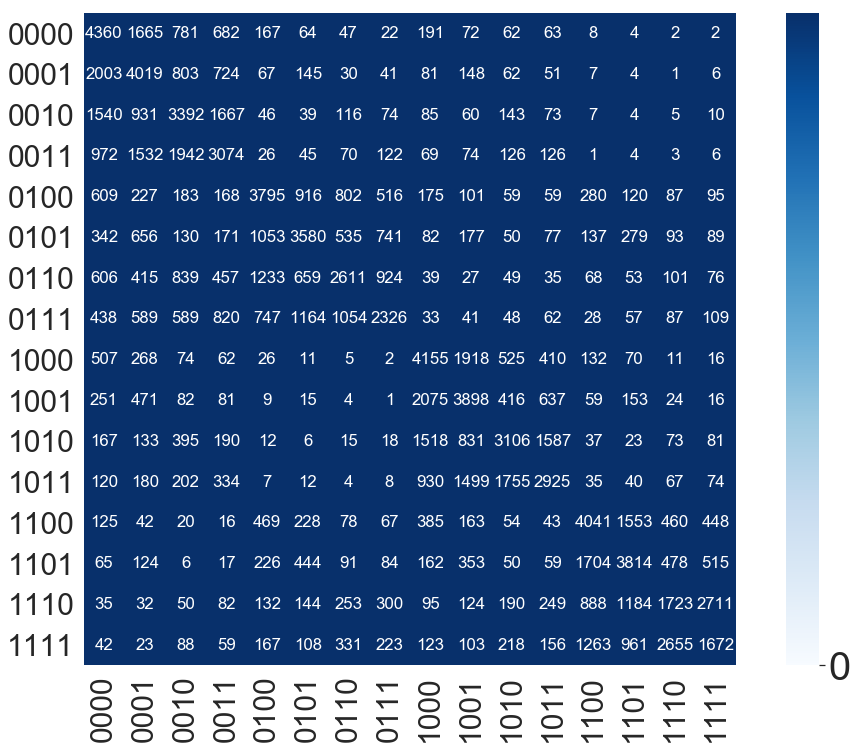

########################## R-C3X_ix ############################


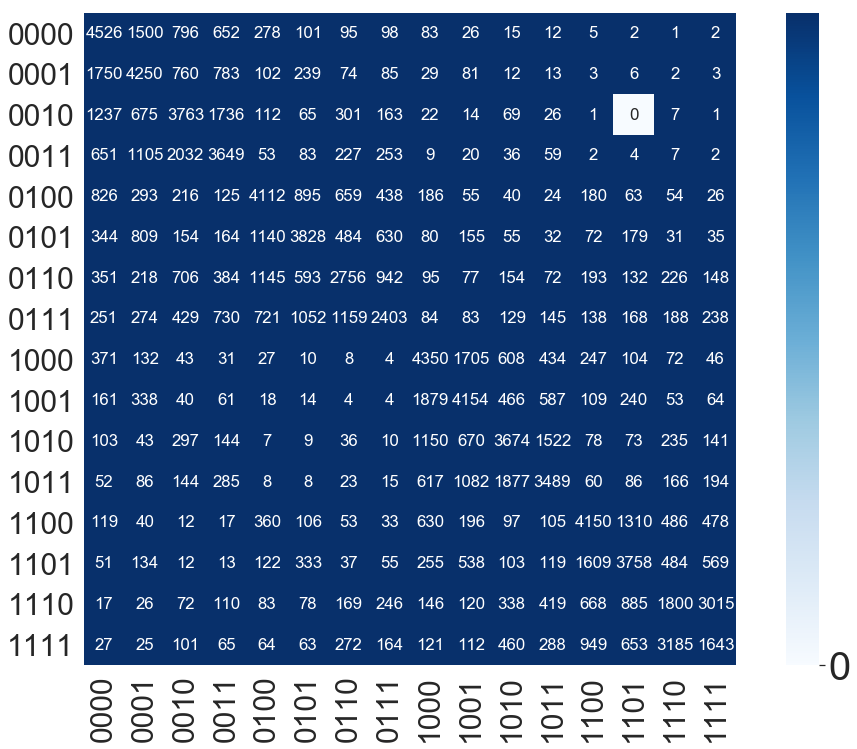

In [153]:
print("########################## R-C3X_m ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(16)]
### labels 
X = [format(num, "04b") for num in range(16)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
# plt.title("R-C3X_m on "+str(device)+"\n", 
#           fontsize=20
#          )

## plot data
sns.set(font_scale=1.4)
sns.heatmap(mean_m, 
            vmin = 0,  ## define maximum value
            vmax=1,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
            fmt = 'g',
            cbar_kws = dict(ticks=[0, 2048, 4096, 6144, 8192])
           )
cax = ax.collections[0].colorbar.ax # ColorbarオブジェクトからカラーバーのAxesオブジェクトにアクセス
# cax = fig.axes[-1] # これでもよい
cax.tick_params(which='minor', direction='in')
cax.tick_params(which='major', labelsize=40)

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=30,
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=30,
          )


# plt.savefig("RC3X_m_ourense_20191224.png", dpi=200, bbox_inches="tight", pad_inches=0.1)
plt.show()

print("########################## R-C3X_ix ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(16)]
### labels 
X = [format(num, "04b") for num in range(16)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
# plt.title("R-C3X_ix on "+str(device)+"\n", 
#           fontsize=20
#          )

## plot data
sns.heatmap(mean_ix, 
            fmt = 'g',
            vmin = 0.0,  ## define maximum value
            vmax=1,   ## defnie minimum value
             annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
            cbar_kws = dict(ticks=[0, 2048, 4096, 6144, 8192])
           )
cax = ax.collections[0].colorbar.ax # ColorbarオブジェクトからカラーバーのAxesオブジェクトにアクセス
# cax = fig.axes[-1] # これでもよい
cax.tick_params(which='minor', direction='in')
cax.tick_params(which='major', labelsize=40)

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=30,
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=30, 
          )
# plt.savefig("RC3X_ix_ourense_20191224.png", dpi=200, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [154]:
shots = 8192
device = 'ibmq_ourense'

mit_mean_m = [[round(pro/shots, 2) if pro>0.0000001 else 0 for pro in mapping] for mapping in mit_mean_m]
mit_mean_ix = [[round(pro/shots, 2) if pro>0.0000001 else 0 for pro in mapping] for mapping in mit_mean_ix]

########################## R-C3X_m ############################


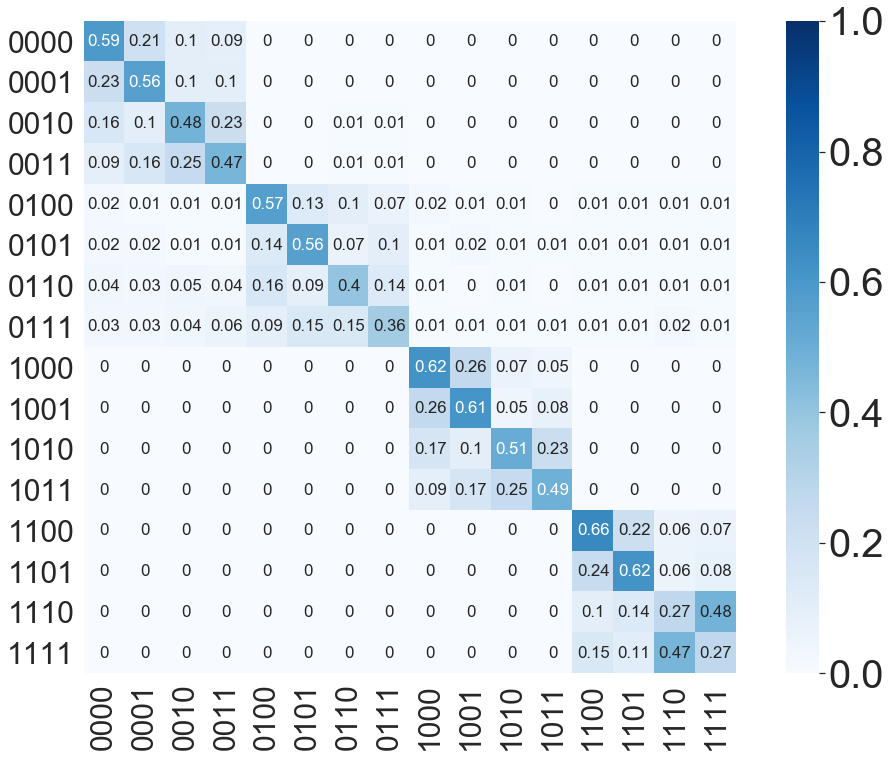

########################## R-C3X_ix ############################


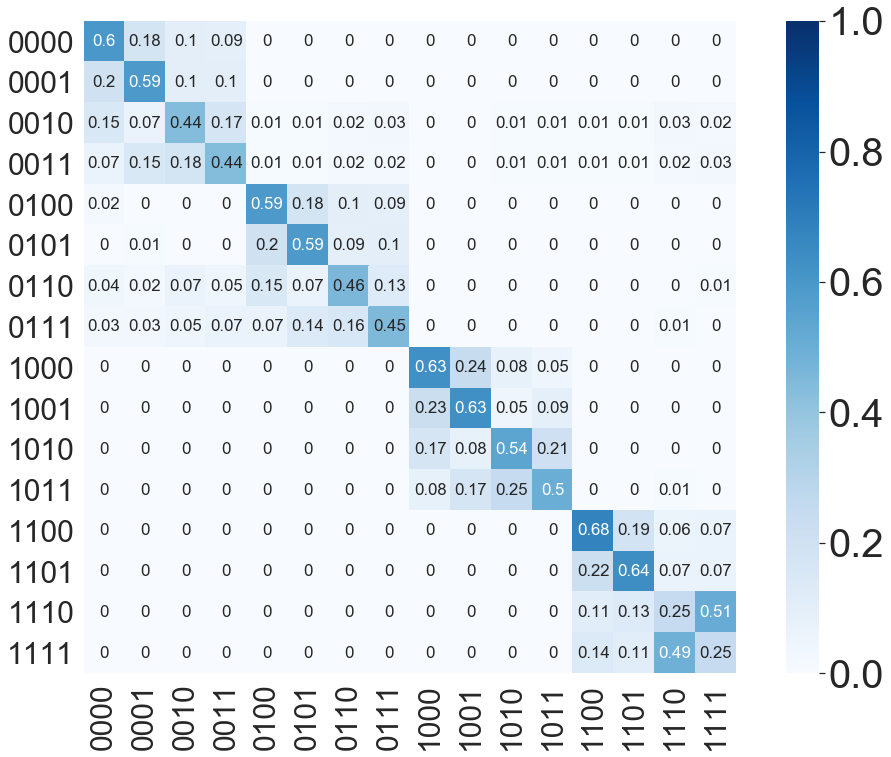

In [155]:
print("########################## R-C3X_m ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(16)]
### labels 
X = [format(num, "04b") for num in range(16)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
# plt.title("R-C3X_m on "+str(device)+"\n", 
#           fontsize=20
#          )

## plot data
sns.set(font_scale=1.4)
sns.heatmap(mit_mean_m, 
            vmin = 0,  ## define maximum value
            vmax=1,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
            fmt = 'g',
#             cbar_kws = dict(ticks=[0, 2048, 4096, 6144, 8192])
           )
cax = ax.collections[0].colorbar.ax # ColorbarオブジェクトからカラーバーのAxesオブジェクトにアクセス
# cax = fig.axes[-1] # これでもよい
cax.tick_params(which='minor', direction='in')
cax.tick_params(which='major', labelsize=40)

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=30,
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=30,
          )


plt.savefig("RC3X_m_ourense_20191224.pdf", dpi=200, bbox_inches="tight", pad_inches=0.1)
plt.show()

print("########################## R-C3X_ix ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(16)]
### labels 
X = [format(num, "04b") for num in range(16)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
# plt.title("R-C3X_ix on "+str(device)+"\n", 
#           fontsize=20
#          )

## plot data
sns.heatmap(mit_mean_ix, 
            fmt = 'g',
            vmin = 0.0,  ## define maximum value
            vmax=1,   ## defnie minimum value
             annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
#             cbar_kws = dict(ticks=[0, 2048, 4096, 6144, 8192])
           )
cax = ax.collections[0].colorbar.ax # ColorbarオブジェクトからカラーバーのAxesオブジェクトにアクセス
# cax = fig.axes[-1] # これでもよい
cax.tick_params(which='minor', direction='in')
cax.tick_params(which='major', labelsize=40)

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=30,
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=30, 
          )
plt.savefig("RC3X_ix_ourense_20191224.pdf", dpi=200, bbox_inches="tight", pad_inches=0.1)
plt.show()

---
# Check Fidelity

In [34]:
mean_m =  [[0.586370635504677, 0.20612408791912173, 0.0956858684607231, 0.08809262628498507, 0.004091337765636305, 0.001062179476840056, 0.004646237879298696, 0.0038165600275530402, 0.002742939594820487, 0.0015454777683620098, 0.0026427672806375317, 0.003145914602348257, 3.806943672910456e-20, 3.336743502199658e-05, 3.3674522737033757e-20, 2.0132438736198433e-20], [0.2274458791368551, 0.5640275763585088, 0.09862936947162036, 0.09588262669775076, 0.0, 0.0018053479132844872, 0.0016327098470085687, 0.0033354340428895088, 0.000478854018773463, 0.0016798224871720307, 0.0026658904625028886, 0.0020416532698601174, 0.00014196732533840395, 4.0623831813895115e-14, 2.639997225816037e-16, 0.00023286896844714635], [0.16339765471294068, 0.09825282101959211, 0.4790080131508324, 0.2317910164427554, 0.0013990623556666235, 0.0008677693582498733, 0.009880603482688292, 0.0064592301700461905, 0.00190590429813117, 0.002231949977826525, 0.0027133775214772185, 0.001262628716664438, 0.0002670340597129717, 9.142130603003113e-05, 3.433800430636254e-19, 0.000471513427445575], [0.08974357303090146, 0.1622184872043564, 0.25267917621455027, 0.46932337646761246, 3.807835843552774e-14, 3.60633869643861e-14, 0.009159222114613227, 0.006597357151354425, 0.0021947443969753257, 0.0016526599536701367, 0.004816829231350099, 0.0016145742349391488, 3.801540942739566e-18, 0.0, 3.182237642361168e-18, 1.637082042495282e-18], [0.017260224795285925, 0.014539677309587462, 0.011322056110099024, 0.009972166870683951, 0.5747379711984919, 0.12611901807347078, 0.10041657045476843, 0.07056762585561317, 0.021236762715059095, 0.009161535434693948, 0.005030066792841559, 0.004560472485015091, 0.012356228853227569, 0.008972800296356196, 0.006652234280636641, 0.007094588474169183], [0.021239472667807784, 0.020420378678669967, 0.007792277793781164, 0.008480076601092304, 0.13724036847113186, 0.5593492194245855, 0.07066609822708844, 0.09904515936338865, 0.008103614195676732, 0.019592472233576526, 0.006057969543227176, 0.006462053008468459, 0.008866221594761298, 0.014244120929799611, 0.006767981293389657, 0.005672515973555097], [0.03697537010464921, 0.02751967267044849, 0.05051505862095586, 0.038846944596381335, 0.15567929621630977, 0.08577252760596202, 0.3983079340620158, 0.13750929817952795, 0.005166189385501464, 0.004729213571953476, 0.008901092865196105, 0.004045316971931271, 0.01282831088243247, 0.010867371628587334, 0.009222690284762167, 0.013113712353385362], [0.027951954215398728, 0.03190350052799963, 0.04371471060399958, 0.05925298002437601, 0.09397805378285778, 0.15233029515781418, 0.1510158370566679, 0.36391732428341195, 0.005210614999954175, 0.005439007603069954, 0.008141275008002838, 0.009372957073855716, 0.007680646205350486, 0.010989647216984512, 0.015222249372314976, 0.013878946867941526], [0.0, 0.0, 0.0, 2.193184767315628e-14, 0.0, 0.0, 1.7086927441217684e-13, 2.3588684311328995e-13, 0.6180012930927521, 0.26191998008925865, 0.06826232181915194, 0.05181640500814829, 6.286572971498308e-13, 9.38661942470438e-13, 1.321766687433707e-12, 1.1271131289317591e-12], [1.6691469650818648e-12, 4.4824682989900975e-12, 2.277288186295568e-13, 3.002487337042065e-13, 1.2215578428182096e-13, 9.714696547508168e-13, 2.0953150689486206e-14, 6.653210251109312e-15, 0.26183034980413983, 0.6088843588344548, 0.05191400912382611, 0.0773712822328951, 1.9616641383951633e-14, 6.72566969609643e-14, 4.1093833210033045e-14, 2.7664811155948313e-14], [1.9490230870598943e-13, 1.628449211190993e-13, 1.0763987232085342e-12, 3.3260709205615314e-13, 3.890233909732142e-14, 4.380949498262531e-14, 1.4178770093772563e-13, 7.86263273289944e-14, 0.16808980368715865, 0.0970777257036049, 0.5060650562808365, 0.22801630241565335, 4.3661229175916796e-14, 6.961866364234673e-14, 0.0, 0.0007511119127441388], [0.0, 0.0, 0.0, 0.0, 2.021352589390933e-13, 3.5900277527639466e-14, 0.0, 0.0, 0.0875260920795081, 0.17157369045396992, 0.25192753048505023, 0.4884313790162955, 7.859321172888252e-13, 6.94875368748091e-13, 0.0005413079738330197, 7.199182133635669e-13], [0.0, 0.0, 0.0, 0.0, 9.827110082400925e-13, 2.7259378701418035e-13, 4.627512051806954e-14, 1.0152038684859025e-13, 0.0001771373739315988, 5.313515357337078e-14, 3.3723227597886616e-15, 2.2666730826279896e-14, 0.6561004892545916, 0.21960969585802387, 0.05868034507073475, 0.06543233244155713], [1.1445918826864416e-13, 6.151364641462685e-13, 2.994964650888827e-14, 5.881761223361244e-14, 3.7850510302644853e-19, 7.332721262359487e-19, 6.64377494242562e-14, 2.205434610004368e-14, 2.409366630042955e-13, 1.760847418003057e-13, 4.1400348450225015e-13, 6.236571483514157e-13, 0.23802345258362725, 0.6224701244770497, 0.06439011757820365, 0.07511630536700001], [3.2598646634135556e-14, 1.0170393652743669e-14, 1.1482350405631158e-13, 1.8255662379278422e-13, 0.0, 0.0, 0.0, 0.0, 0.0006987179950465929, 3.572333956461151e-14, 0.0012782640769926513, 4.277048073514509e-14, 0.10159486505862074, 0.14433469534185842, 0.26821595530408526, 0.4838775022260336], [1.0898759691038773e-14, 7.45395351233993e-14, 1.8372131336101525e-13, 1.2349702041922097e-13, 1.0164985778392614e-17, 4.802739728986396e-18, 2.72419668921966e-17, 1.2467896690025788e-17, 2.1573023235046447e-14, 1.725546151893819e-13, 2.97143138331629e-14, 0.0007327491838438105, 0.148243860747095, 0.11190243454854898, 0.46785403289480654, 0.2712669226283868]]
mean_ix =  [[0.6001107893106122, 0.18443783332201497, 0.09825927794044029, 0.09048468073370859, 0.0033728364239057743, 0.0016929709284343325, 0.004286920181398901, 0.004733223296222397, 0.0021481414389856617, 0.0031945079342665045, 0.0022228424204890785, 0.004500146600899509, 0.0001823223762532279, 2.9431033718298664e-15, 0.00019894825947141826, 0.00017455883289424113], [0.19742959559703305, 0.5883834443710254, 0.09719060300080183, 0.09638365868998859, 0.0013045112537560157, 0.004083126856865533, 0.0038902535099521007, 0.002428244511158136, 0.0017870641263028682, 0.002365032174448816, 0.0026853875514108727, 0.0017164034683370293, 6.885763342170233e-05, 6.095838099933343e-14, 0.00021229285797162587, 7.152439746678742e-05], [0.1528209200627749, 0.07377807006370773, 0.44354021946929745, 0.16642097972212033, 0.013411257583498638, 0.013190453364813778, 0.02323905007661719, 0.027875152921444622, 0.004079682359948232, 0.00341436945796235, 0.005988141991334857, 0.006236493485513727, 0.012931522090268781, 0.008008239403451913, 0.029875221857761272, 0.015190226089484274], [0.07481493978054872, 0.1462414798311592, 0.17977206085648056, 0.4404369579175802, 0.013446976589397874, 0.01123948791400707, 0.024851918830442805, 0.024353011154422226, 0.0028158568485308058, 0.0014479511687304177, 0.007183451937028596, 0.005404368140259133, 0.007359866693163348, 0.013024565586714307, 0.019145224488021948, 0.028461882263513552], [0.015892218543478137, 0.0035799524897079903, 0.002463733452446818, 0.0034253059226798527, 0.5862127081026826, 0.1839302329628651, 0.10156279694938977, 0.0901923738082834, 0.0, 6.892366008468656e-18, 1.1687509305847766e-17, 0.00022705139113338981, 0.0026460308029647665, 0.0030849679580042966, 0.0027937490619740868, 0.003988878554533527], [0.0016179839003611991, 0.013853352283848106, 0.0027140452994992557, 0.0006824970297370402, 0.1981786095620971, 0.586071696354115, 0.09297309372134288, 0.09673356774131224, 1.0493033177964558e-16, 0.0, 0.0, 0.0, 0.0016707346539705425, 0.0007429348966925806, 0.0031851569652920474, 0.0015763275919077077], [0.03571278936065531, 0.023357333774594, 0.07330721504714012, 0.04879069873191362, 0.15178452108163726, 0.06545919079279057, 0.4614286935297408, 0.12747215671960466, 0.0010043039906551749, 0.0017014863319626493, 0.0, 0.0006906088961216114, 0.0012631190897860857, 0.001375826305896764, 0.0011719413035323808, 0.005480115044367991], [0.026949796315180102, 0.028555206216656477, 0.047112350595818364, 0.07263379344693931, 0.06858777804850613, 0.14088754010844773, 0.1562101006871207, 0.4479759217058567, 0.0005257273699519091, 0.0011901360506808305, 0.0006650087579582139, 0.0007528330221497507, 0.0012354086443361813, 0.001331521578145438, 0.005386877452339804, 8.833130889208761e-19], [3.345542657333679e-17, 1.1727042683797389e-17, 2.244207077288166e-18, 8.110852024419625e-16, 2.132877110218025e-18, 1.9271938248191165e-19, 2.8006916865222346e-14, 4.353248285099775e-14, 0.6316759204909407, 0.23669635029101838, 0.07810576130489313, 0.053521967914613, 2.2140642252643805e-13, 1.2600136235709712e-13, 1.0915926039820356e-13, 1.177359118038426e-13], [3.5540620943196797e-14, 1.2719235540763025e-13, 1.6670452481150163e-19, 1.1342164147531387e-14, 9.07160436412859e-16, 1.2928918164642646e-14, 4.5751658399142254e-14, 2.688468662883162e-15, 0.23348625120654087, 0.6312769785230474, 0.04952642966483804, 0.08571034060754626, 1.3836549272320157e-13, 4.183618293878631e-13, 2.5023991892941686e-13, 3.235234377761822e-13], [4.728532769085033e-19, 1.733977908353153e-19, 2.162306056555544e-18, 7.413848819019821e-19, 5.976298767476951e-20, 7.436465692043955e-14, 4.066887391040015e-19, 1.1209369148885898e-14, 0.17354328530372062, 0.08109172099972743, 0.5369226824610502, 0.20811636032445613, 6.397866932077965e-13, 9.195609980590566e-13, 4.1869711811288254e-13, 0.00032595092123111573], [0.0, 7.512409885900868e-15, 8.0016686124767e-15, 1.8117826033261963e-14, 7.1196570082303475e-16, 6.347777251209671e-16, 7.483567284111245e-16, 2.616765395910041e-15, 0.07977425095122004, 0.16922523577676335, 0.24657009897703053, 0.49912877523341714, 3.199315246132802e-15, 2.2533294552587124e-15, 0.005301639061575936, 3.0029295834189856e-15], [1.8932435759030753e-13, 5.0513608291785574e-14, 1.0496453502145158e-13, 6.43936705226801e-14, 0.0, 0.0, 2.0026262701488403e-17, 8.176173308196525e-18, 0.0, 1.773284357224035e-13, 2.1648479355851957e-13, 1.3556899895359252e-13, 0.6804897941244399, 0.1927158083413138, 0.061208495705779645, 0.06558590183161336], [0.0, 1.0536241001048538e-14, 2.0204138108837894e-14, 2.569076077708578e-15, 0.0, 0.0, 4.864073255853191e-15, 3.326540160985198e-14, 0.0, 6.199272621725961e-15, 8.12284644870282e-15, 1.4158635981061576e-14, 0.2218726363975746, 0.6418817516917377, 0.0659029996220721, 0.07034261228967476], [4.486088906736791e-15, 4.0671940214279975e-14, 6.002750089027557e-14, 5.796446665107394e-14, 0.0, 0.0, 0.0, 0.0, 1.6932304321077684e-13, 8.153752959846787e-14, 2.308719549680374e-13, 0.0, 0.10596630001652993, 0.1297502226829791, 0.25472911897954603, 0.5095543583232494], [6.392602458769224e-14, 3.244178870029852e-14, 2.4618465103733116e-13, 6.301231934069618e-14, 1.3413005713860622e-18, 4.826919650870107e-19, 2.266789858772257e-18, 1.251556482023784e-18, 1.0944328880956561e-13, 1.5442901826384387e-13, 1.536512899453859e-18, 0.0024726152013676604, 0.14041589873923946, 0.10900788912851725, 0.4946015883330684, 0.25350200860048633]]

In [35]:
sim_m_data  = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]
sim_ix_data  = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]


In [36]:
dens_exp_m = [[col/16 for col in row] for row in mean_m]
dens_sim_m = [[col/16 for col in row] for row in sim_m_data]
dens_exp_ix = [[col/16 for col in row] for row in mean_ix]
dens_sim_ix = [[col/16 for col in row] for row in sim_ix_data]

In [37]:
F_rc3x_m_ourense_20191224 = np.trace(np.sqrt(np.dot(dens_exp_m, dens_sim_m)))
F_rc3x_ix_ourense_20191224 = np.trace(np.sqrt(np.dot(dens_exp_ix, dens_sim_ix)))
print("F_rc3x_m_ourense_20191224 = ", F_rc3x_m_ourense_20191224, "\n")
print("F_rc3x_ix_ourense_20191224 = ", F_rc3x_ix_ourense_20191224, "\n")

F_rc3x_m_ourense_20191224 =  0.7243504429769464 

F_rc3x_ix_ourense_20191224 =  0.738932480136807 

